# Cora Dataset — Full Graph Embedding Pipeline

**Dataset**: ~2708 papers, 7 classes, 1433-d BoW features, directed citation edges

**Part A** — Node Classification: BoW baseline → Laplacian Eigenmaps → Node2Vec → GCN → GraphSAGE → GAT → R-GCN

**Part B** — Link Prediction: Node2Vec + Scoring → TransE → GCN decoder → GAT decoder

## Notebook Outline

This notebook explores graph embedding techniques on the **Cora citation network**, progressing from shallow methods to deep Graph Neural Networks (GNNs). It is divided into two main tasks:

**Part A: Node Classification (Predicting Paper Topics)**
*   **Baselines:** 
    *   *BoW + LR* (Features only)
    *   *Laplacian Eigenmaps* (Structure only, Spectral)
    *   *Node2Vec* (Structure only, Random walks + Grid Search)
*   **Deep Graph Models (Structure + Features):**
    *   *GCN* 
    *   *GraphSAGE* 
    *   *GAT* 
    *   *R-GCN* (To test the use of directed edges)
    *   Depth/Over-smoothing experiment
*   **Analysis:** Comparative performance, t-SNE visualizations

**Part B: Link Prediction (Predicting Citations)**
*   **Setup:** Edge splitting and negative sample generation.
*   **Models:** Node2Vec scoring, TransE (Translational embeddings), and GCN/GAT Autoencoders.
*   **Analysis:** Evaluation using ROC-AUC and Average Precision.

**Cross-Cutting Analysis**
*   Final synthesis addressing the value of graph structure, node features, layer depth, and edge directionality.


## Connections Between Part 1 and Part 2

Part 1 **explored** the Cora citation graph — understanding its structure through network statistics, centrality analysis, and community detection. Part 2 **exploits** that structure by learning graph embeddings for two downstream tasks: **node classification** and **link prediction**.

### From Understanding Structure to Learning From It

Part 1 established that Cora's citation network has meaningful structure: high modularity (0.82), clear community organization, and citation patterns that vary across research domains. Part 2 takes this as a starting point — if the graph has exploitable structure, can we learn vector representations (embeddings) that capture it well enough for prediction?

The pipeline in Part 2 is designed to answer this progressively:
- **Structure-only embeddings** (Laplacian Eigenmaps, Node2Vec) — learn from the graph topology alone, similar in spirit to Part 1's structure-only community detection
- **Structure + features** (GCN, GraphSAGE, GAT, R-GCN) — combine the citation graph with 1433-d BoW features, testing whether node content improves over structure alone
- **A feature-only baseline** (BoW + LR) — isolates the contribution of graph structure by removing it entirely

### Directed vs. Undirected — Continued

Part 1 worked with both directed and undirected representations, noting that centrality measures like PageRank and in-degree exploit directionality while others require undirected graphs. Part 2 continues this comparison: GCN/GraphSAGE/GAT treat citations as undirected, while **R-GCN** preserves direction with separate `cites` and `cited_by` relations, and **TransE** models each citation as a directed translation. This would allow us to understand the relative contributions of directionality in the downstream tasks.

### Citation Patterns → Link Prediction

Part 1 analyzed inter- and intra-class citation patterns. Part 2's **link prediction** task is the natural ML extension: rather than just describing citation patterns, can a model predict which citations should exist? This tests whether the structural regularities observed in Part 1 can be captured by learned embeddings.

---

**In short**, Part 1 asks *"what does the Cora graph look like?"* — Part 2 asks *"can we learn useful representations from it?"*


## 0.1 — Install Dependencies (Colab)

In [26]:
# ==============================================================================
# Install PyTorch Geometric and dependencies for Google Colab
# ==============================================================================
# Uncomment and run these if needed:
# !pip install torch==2.5.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install torch-geometric
# !pip install pyg-lib torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.5.1+cu121.html

## 0.2 — Imports & Configuration

In [27]:
# ==============================================================================
# Imports
# ==============================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec, GCNConv, SAGEConv, GATConv, RGCNConv
from torch_geometric.utils import to_undirected, negative_sampling
from torch_geometric.transforms import RandomLinkSplit

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import cdist

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


---
## Step 1 — Load & Build the Graph

Parse `cora.content` (paper IDs, 1433-d BoW features, class labels) and `cora.cites` (directed citation edges).
Build a PyTorch Geometric `Data` object with both directed and undirected edge representations.

In [28]:
# ==============================================================================
# 1.1  Mount Google Drive and set data path
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = "/content/drive/MyDrive/cora"  # adjust this path if needed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# ==============================================================================
# 1.2  Load cora.content — node features and labels
# ==============================================================================
content_path = os.path.join(DATA_DIR, "cora.content")
content_data = []
with open(content_path, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        content_data.append(parts)

paper_ids   = [row[0] for row in content_data]
features    = np.array([row[1:-1] for row in content_data], dtype=np.float32)
labels_str  = [row[-1] for row in content_data]

# Encode labels
class_names = sorted(set(labels_str))
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
labels = np.array([class_to_idx[l] for l in labels_str])

print(f"Number of papers (nodes):  {len(paper_ids)}")
print(f"Feature matrix shape:      {features.shape}")
print(f"Number of classes:         {len(class_names)}")
print(f"\nClass distribution:")
for name, idx in class_to_idx.items():
    count = (labels == idx).sum()
    print(f"  {idx}: {name:30s} ({count} papers)")

Number of papers (nodes):  2708
Feature matrix shape:      (2708, 1433)
Number of classes:         7

Class distribution:
  0: Case_Based                     (298 papers)
  1: Genetic_Algorithms             (418 papers)
  2: Neural_Networks                (818 papers)
  3: Probabilistic_Methods          (426 papers)
  4: Reinforcement_Learning         (217 papers)
  5: Rule_Learning                  (180 papers)
  6: Theory                         (351 papers)


In [30]:
# ==============================================================================
# 1.3  Load cora.cites — directed citation edges
# ==============================================================================
paper_id_to_idx = {pid: i for i, pid in enumerate(paper_ids)}

cites_path = os.path.join(DATA_DIR, "cora.cites")
edges = []
skipped = 0

with open(cites_path, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        cited  = parts[0]   # paper being cited
        citing = parts[1]   # paper doing the citing

        if cited in paper_id_to_idx and citing in paper_id_to_idx:
            src = paper_id_to_idx[citing]   # citing → source
            dst = paper_id_to_idx[cited]    # cited  → destination
            edges.append([src, dst])
        else:
            skipped += 1

edge_index_directed = torch.tensor(edges, dtype=torch.long).t().contiguous()
print(f"Directed edges loaded:       {edge_index_directed.shape[1]}")
print(f"Edges skipped (missing IDs): {skipped}")

Directed edges loaded:       5429
Edges skipped (missing IDs): 0


In [31]:
# ==============================================================================
# 1.4  Build PyTorch Geometric Data object
# ==============================================================================
x = torch.tensor(features, dtype=torch.float)    # [2708, 1433]
y = torch.tensor(labels, dtype=torch.long)        # [2708]

# Undirected version (standard for GCN/GAT/GraphSAGE)
edge_index_undirected = to_undirected(edge_index_directed)

# Primary Data object uses undirected edges
data = Data(x=x, edge_index=edge_index_undirected, y=y)
data.num_classes = len(class_names)

# Store directed edges for R-GCN and link prediction
data.edge_index_directed = edge_index_directed

print(f"\nGraph summary:")
print(f"  Nodes:                 {data.num_nodes}")
print(f"  Edges (directed):      {edge_index_directed.shape[1]}")
print(f"  Edges (undirected):    {data.num_edges}")
print(f"  Node feature dim:      {data.num_node_features}")
print(f"  Classes:               {data.num_classes}")
print(f"  Avg degree (undir):    {data.num_edges / data.num_nodes:.1f}")


Graph summary:
  Nodes:                 2708
  Edges (directed):      5429
  Edges (undirected):    10556
  Node feature dim:      1433
  Classes:               7
  Avg degree (undir):    3.9


---
## Step 2 — Homophily Measurement

Compute the homophily ratio: fraction of edges where both endpoints share the same class label.

`H = |{(u,v) ∈ E : label(u) == label(v)}| / |E|`

High homophily (Cora ≈ 0.81) means citation links correlate strongly with research topic — GNNs should benefit.

In [32]:
# ==============================================================================
# 2.1  Compute homophily ratio (on directed edges)
# ==============================================================================
src_labels = y[edge_index_directed[0]].numpy()
dst_labels = y[edge_index_directed[1]].numpy()
same_label = (src_labels == dst_labels).sum()
total_edges = edge_index_directed.shape[1]

homophily = same_label / total_edges
print(f"Homophily ratio (directed edges): {homophily:.4f}")
print(f"  {same_label} / {total_edges} edges connect same-class nodes")
print(f"\nInterpretation: {'High' if homophily > 0.7 else 'Moderate' if homophily > 0.4 else 'Low'} homophily")
print(f"  → GNNs should {'strongly' if homophily > 0.7 else 'moderately'} benefit from message passing")

Homophily ratio (directed edges): 0.8138
  4418 / 5429 edges connect same-class nodes

Interpretation: High homophily
  → GNNs should strongly benefit from message passing


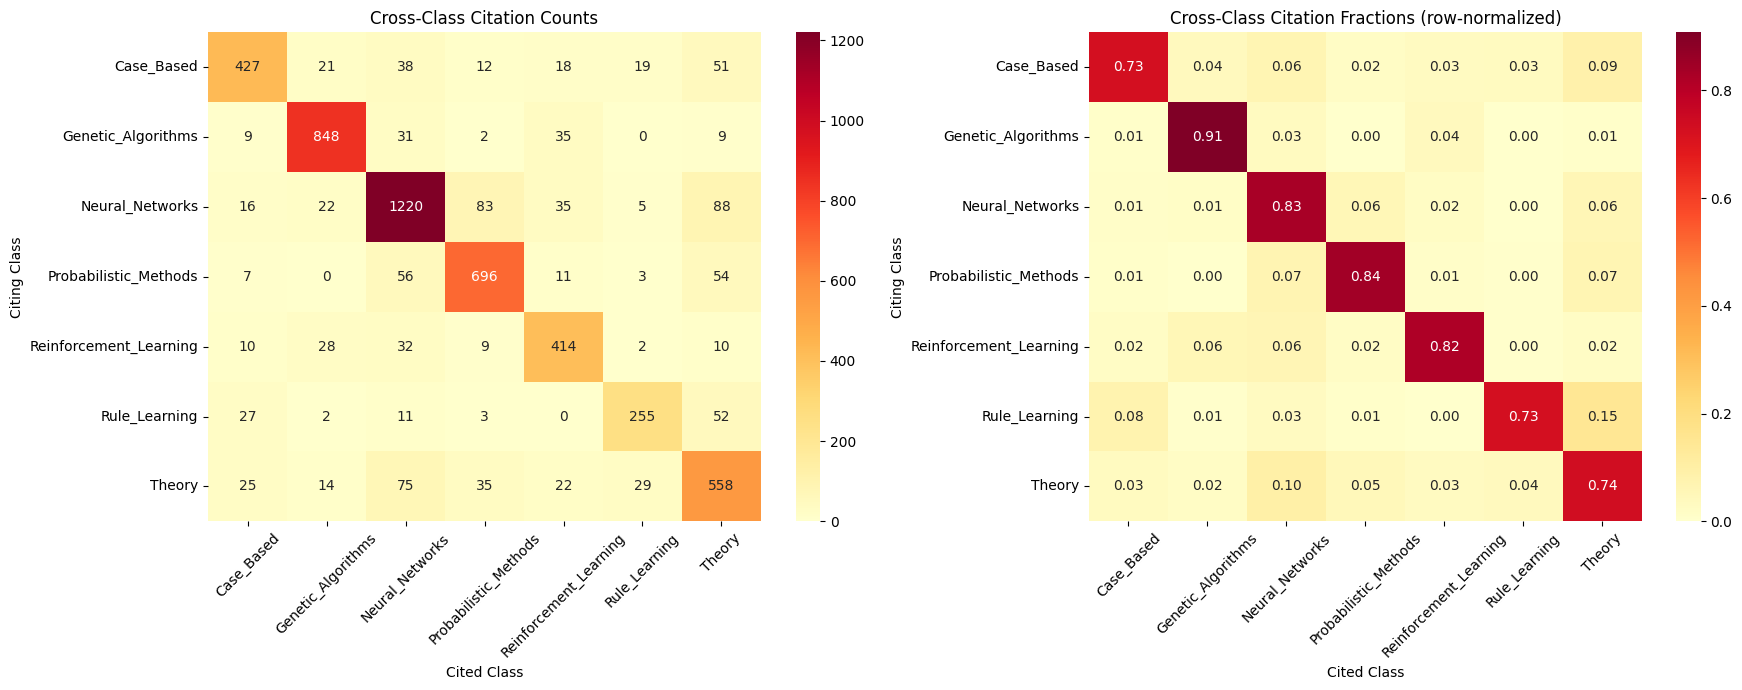


Key observations:
  • Diagonal dominance confirms high homophily — papers mostly cite within their field
  • Off-diagonal entries reveal inter-field citation patterns


In [33]:
# ==============================================================================
# 2.2  Cross-class citation heatmap (7×7)
# ==============================================================================
cross_class = np.zeros((len(class_names), len(class_names)), dtype=int)
for i in range(edge_index_directed.shape[1]):
    s = y[edge_index_directed[0, i]].item()
    d = y[edge_index_directed[1, i]].item()
    cross_class[s, d] += 1

# Normalize rows to show citation fractions
row_sums = cross_class.sum(axis=1, keepdims=True)
cross_class_norm = cross_class / np.maximum(row_sums, 1)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Raw counts
sns.heatmap(cross_class, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Cited Class')
axes[0].set_ylabel('Citing Class')
axes[0].set_title('Cross-Class Citation Counts')
axes[0].tick_params(axis='x', rotation=45)

# Normalized (row fractions)
sns.heatmap(cross_class_norm, annot=True, fmt='.2f', cmap='YlOrRd',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Cited Class')
axes[1].set_ylabel('Citing Class')
axes[1].set_title('Cross-Class Citation Fractions (row-normalized)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nKey observations:")
print("  • Diagonal dominance confirms high homophily — papers mostly cite within their field")
print("  • Off-diagonal entries reveal inter-field citation patterns")

---
## Step 3 — Train / Validation / Test Split

Stratified random split (60% / 20% / 20%) preserving class proportions.
The same masks are used for **all** node classification methods for fair comparison.

In [34]:
# ==============================================================================
# 3.1  Create stratified train/val/test masks (60% / 20% / 20%)
# ==============================================================================
num_nodes = data.num_nodes
indices = np.arange(num_nodes)

# First split: 60% train, 40% temp (val + test)
train_idx, temp_idx = train_test_split(
    indices, test_size=0.4, stratify=labels, random_state=SEED
)
# Second split: 50% of temp → 20% val, 20% test
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=labels[temp_idx], random_state=SEED
)

# Create boolean masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask   = torch.zeros(num_nodes, dtype=torch.bool)
test_mask  = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True

data.train_mask = train_mask
data.val_mask   = val_mask
data.test_mask  = test_mask

print(f"Train: {train_mask.sum().item()} nodes ({train_mask.sum().item()/num_nodes*100:.1f}%)")
print(f"Val:   {val_mask.sum().item()} nodes ({val_mask.sum().item()/num_nodes*100:.1f}%)")
print(f"Test:  {test_mask.sum().item()} nodes ({test_mask.sum().item()/num_nodes*100:.1f}%)")

# Verify stratification
print(f"\nClass distribution check:")
for i, name in enumerate(class_names):
    tr = (labels[train_idx] == i).sum()
    va = (labels[val_idx] == i).sum()
    te = (labels[test_idx] == i).sum()
    print(f"  {name:30s}  train={tr:3d}  val={va:3d}  test={te:3d}")

Train: 1624 nodes (60.0%)
Val:   542 nodes (20.0%)
Test:  542 nodes (20.0%)

Class distribution check:
  Case_Based                      train=179  val= 59  test= 60
  Genetic_Algorithms              train=251  val= 84  test= 83
  Neural_Networks                 train=491  val=164  test=163
  Probabilistic_Methods           train=255  val= 85  test= 86
  Reinforcement_Learning          train=130  val= 44  test= 43
  Rule_Learning                   train=108  val= 36  test= 36
  Theory                          train=210  val= 70  test= 71


---
# Part A — Node Classification

---
## Baseline 0 — Feature-Only (BoW + Logistic Regression)

Train a Logistic Regression classifier directly on the raw 1433-d Bag-of-Words features.
**No graph structure used** — this answers: *how much do the text features alone tell us?*

In [35]:
# ==============================================================================
# 4.1  BoW + Logistic Regression (no graph)
# ==============================================================================
X_train_bow = features[train_mask.numpy()]
y_train_bow = labels[train_mask.numpy()]
X_val_bow   = features[val_mask.numpy()]
y_val_bow   = labels[val_mask.numpy()]
X_test_bow  = features[test_mask.numpy()]
y_test_bow  = labels[test_mask.numpy()]

clf_bow = LogisticRegression(max_iter=2000, multi_class='multinomial',
                             solver='lbfgs', random_state=SEED)
clf_bow.fit(X_train_bow, y_train_bow)

y_val_pred_bow  = clf_bow.predict(X_val_bow)
y_test_pred_bow = clf_bow.predict(X_test_bow)

acc_bow = accuracy_score(y_test_bow, y_test_pred_bow)
f1_bow  = f1_score(y_test_bow, y_test_pred_bow, average='macro')

print(f"BoW + LR  —  Test Accuracy: {acc_bow:.4f}  |  Macro F1: {f1_bow:.4f}")
print(f"\nClassification Report (Test Set):")
print(classification_report(y_test_bow, y_test_pred_bow, target_names=class_names, digits=3))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


BoW + LR  —  Test Accuracy: 0.7583  |  Macro F1: 0.7428

Classification Report (Test Set):
                        precision    recall  f1-score   support

            Case_Based      0.784     0.667     0.721        60
    Genetic_Algorithms      0.880     0.880     0.880        83
       Neural_Networks      0.711     0.859     0.778       163
 Probabilistic_Methods      0.787     0.686     0.733        86
Reinforcement_Learning      0.737     0.651     0.691        43
         Rule_Learning      0.774     0.667     0.716        36
                Theory      0.701     0.662     0.681        71

              accuracy                          0.758       542
             macro avg      0.768     0.724     0.743       542
          weighted avg      0.762     0.758     0.756       542



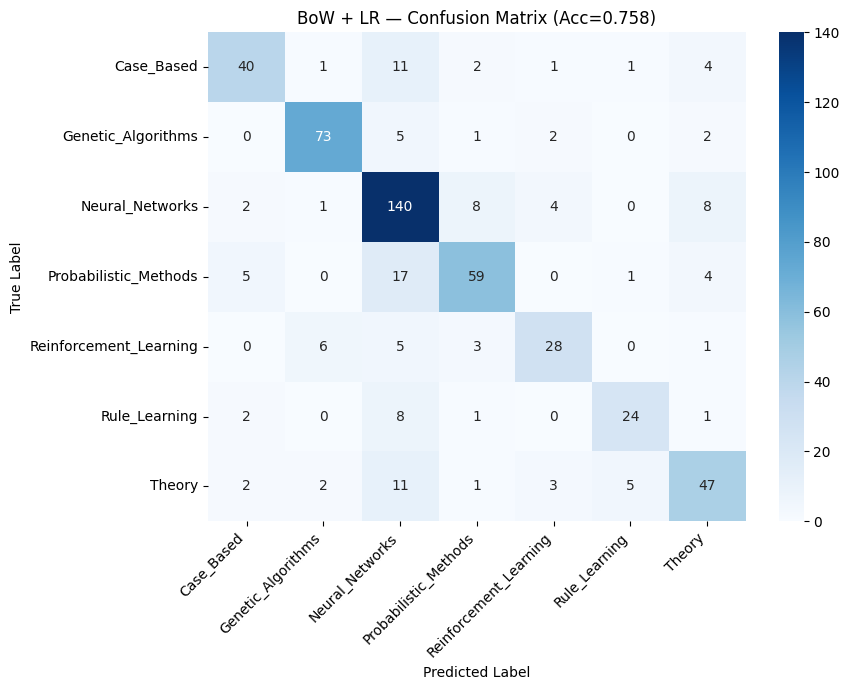

In [36]:
# ==============================================================================
# 4.2  Confusion Matrix — BoW + LR
# ==============================================================================
cm_bow = confusion_matrix(y_test_bow, y_test_pred_bow)
plt.figure(figsize=(9, 7))
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'BoW + LR — Confusion Matrix (Acc={acc_bow:.3f})')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Storage for results

We collect all method results in dictionaries for comparative analysis later.

In [37]:
# ==============================================================================
# Results storage for Part A
# ==============================================================================
results_a = {}   # {method_name: {'accuracy': ..., 'f1_macro': ..., 'f1_per_class': ..., 'embeddings': ...}}

# Helper to store results and optionally run t-SNE
def store_result(name, y_true, y_pred, embeddings=None, uses_graph=False,
                 uses_features=False, inductive=False, extra_info=""):
    acc = accuracy_score(y_true, y_pred)
    f1_mac = f1_score(y_true, y_pred, average='macro')
    f1_per = f1_score(y_true, y_pred, average=None)
    f1_wt = f1_score(y_true, y_pred, average='weighted')
    results_a[name] = {
        'accuracy': acc, 'f1_macro': f1_mac, 'f1_per_class': f1_per,
        'f1_weighted': f1_wt,
        'y_true': y_true, 'y_pred': y_pred,
        'embeddings': embeddings,
        'uses_graph': uses_graph, 'uses_features': uses_features,
        'inductive': inductive, 'extra_info': extra_info,
    }
    print(f"Stored results for '{name}': Acc={acc:.4f}, Macro F1={f1_mac:.4f}")

# Store BoW baseline
store_result('BoW + LR', y_test_bow, y_test_pred_bow,
             embeddings=features,  # raw features as "embeddings" for t-SNE
             uses_graph=False, uses_features=True, inductive=True)

Stored results for 'BoW + LR': Acc=0.7583, Macro F1=0.7428


---
## Baseline 1 — Laplacian Eigenmaps (Spectral, Structure Only)

Compute the normalized graph Laplacian `L = D⁻¹/² (D - A) D⁻¹/²` on the undirected graph.
Extract the bottom-k eigenvectors (k=128) as node embeddings — these capture global community structure.
No node features or labels are used during embedding computation.

#### Why Not Use the Eigengap Heuristic to choose $k$?
The **Eigengap Heuristic** (choosing $k$ based on the largest jump between eigenvalues) is mathematically optimal for finding the number of macro-communities in pure clustering tasks. However, it will result in a very small $k=7$ for Cora's main topics. For downstream **supervised classification**, a larger dimension like $k=128$ performs better because it preserves fine-grained structural nuances (like local sub-communities) that a strict eigengap cutoff would discard.


In [38]:
# ==============================================================================
# 5.1  Compute Laplacian Eigenmaps (spectral embeddings, k=128)
# ==============================================================================
from scipy.sparse import eye as speye

# Build sparse adjacency matrix from undirected edges
num_n = data.num_nodes
row = data.edge_index[0].numpy()
col = data.edge_index[1].numpy()
vals = np.ones(len(row), dtype=np.float64)
A = csr_matrix((vals, (row, col)), shape=(num_n, num_n))

# Degree matrix
degrees = np.array(A.sum(axis=1)).flatten()
degrees_inv_sqrt = np.where(degrees > 0, 1.0 / np.sqrt(degrees), 0.0)
D_inv_sqrt = csr_matrix((degrees_inv_sqrt, (np.arange(num_n), np.arange(num_n))),
                         shape=(num_n, num_n))

# Normalized Laplacian: L_norm = I - D^{-1/2} A D^{-1/2}
L_norm = speye(num_n) - D_inv_sqrt @ A @ D_inv_sqrt

# Extract bottom-k eigenvectors (skip the trivial eigenvector for lambda=0)
K_DIM = 128
print(f"Computing {K_DIM} smallest eigenvectors of the normalized Laplacian...")
eigenvalues, eigenvectors = eigsh(L_norm, k=K_DIM + 1, which='SM')

# Sort by eigenvalue and skip the first (trivial) one
sort_idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sort_idx]
eigenvectors = eigenvectors[:, sort_idx]

spectral_embeddings_raw = eigenvectors[:, 1:K_DIM + 1]  # skip lambda_0 ≈ 0

# Weight each eigenvector dimension by 1/sqrt(eigenvalue) — this makes dimensions
# with smaller eigenvalues (= more global structure) contribute proportionally.
eig_weights = 1.0 / np.sqrt(np.maximum(eigenvalues[1:K_DIM + 1], 1e-10))
spectral_embeddings = spectral_embeddings_raw * eig_weights[np.newaxis, :]

print(f"Spectral embedding shape: {spectral_embeddings.shape}")
print(f"Smallest eigenvalues: {eigenvalues[:6]}")

Computing 128 smallest eigenvectors of the normalized Laplacian...
Spectral embedding shape: (2708, 128)
Smallest eigenvalues: [-1.38364660e-15 -1.28653135e-15 -7.77947425e-16 -5.52870985e-16
 -4.99536363e-16 -4.32795855e-16]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Laplacian Eigenmaps + LR  —  Test Accuracy: 0.8155

Classification Report:
                        precision    recall  f1-score   support

            Case_Based      0.821     0.767     0.793        60
    Genetic_Algorithms      0.928     0.928     0.928        83
       Neural_Networks      0.780     0.890     0.831       163
 Probabilistic_Methods      0.929     0.756     0.833        86
Reinforcement_Learning      0.755     0.860     0.804        43
         Rule_Learning      0.839     0.722     0.776        36
                Theory      0.687     0.648     0.667        71

              accuracy                          0.815       542
             macro avg      0.820     0.796     0.805       542
          weighted avg      0.820     0.815     0.815       542



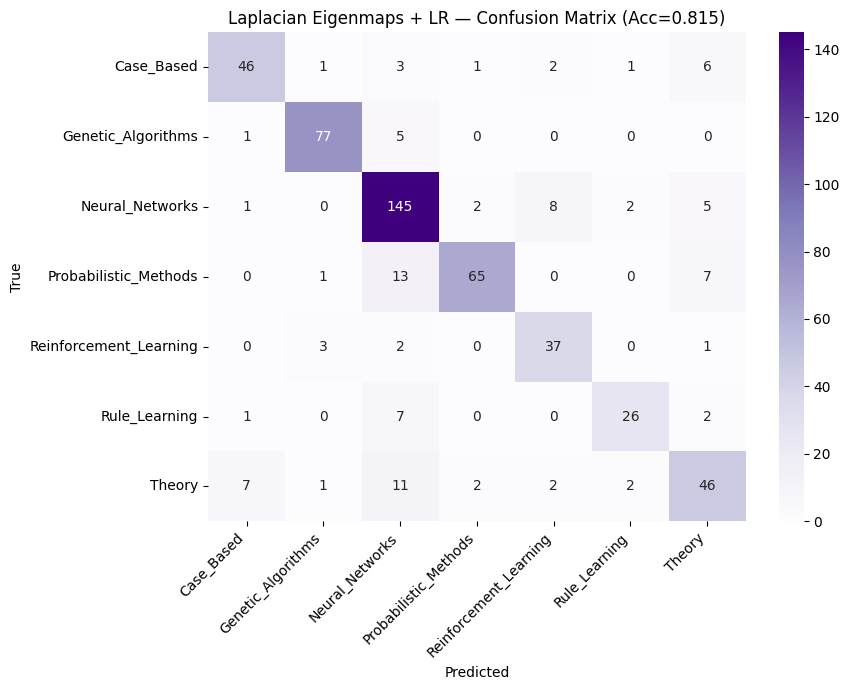

Stored results for 'Laplacian Eigenmaps + LR': Acc=0.8155, Macro F1=0.8046


In [39]:
# ==============================================================================
# 5.2  Logistic Regression on Laplacian Eigenmaps
# ==============================================================================
from sklearn.preprocessing import StandardScaler

# IMPORTANT: raw eigenvectors have wildly different scales — StandardScaler
# prevents the classifier from collapsing to predict the majority class.
scaler_spec = StandardScaler()
spectral_scaled = scaler_spec.fit_transform(spectral_embeddings)

X_train_spec = spectral_scaled[train_mask.numpy()]
y_train_spec = labels[train_mask.numpy()]
X_test_spec  = spectral_scaled[test_mask.numpy()]
y_test_spec  = labels[test_mask.numpy()]

clf_spec = LogisticRegression(max_iter=2000, multi_class='multinomial',
                               solver='lbfgs', random_state=SEED, C=1.0)
clf_spec.fit(X_train_spec, y_train_spec)

y_test_pred_spec = clf_spec.predict(X_test_spec)
acc_spec = accuracy_score(y_test_spec, y_test_pred_spec)

print(f"Laplacian Eigenmaps + LR  —  Test Accuracy: {acc_spec:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test_spec, y_test_pred_spec, target_names=class_names, digits=3))

# Confusion matrix
cm_spec = confusion_matrix(y_test_spec, y_test_pred_spec)
plt.figure(figsize=(9, 7))
sns.heatmap(cm_spec, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title(f'Laplacian Eigenmaps + LR — Confusion Matrix (Acc={acc_spec:.3f})')
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

store_result('Laplacian Eigenmaps + LR', y_test_spec, y_test_pred_spec,
             embeddings=spectral_scaled,
             uses_graph=True, uses_features=False, inductive=False)

---
## Baseline 2 — Node2Vec (Structure Only)

Node2Vec learns embeddings via **biased random walks** + **Skip-Gram with Negative Sampling**.
The model never sees BoW features or class labels during embedding training.

Parameters: `embedding_dim=128`, `walk_length=80`, `context_size=10`, `walks_per_node=10`

### Node2Vec Configuration Rationale

- **`embedding_dim = 128`**: Standard dimension from the original Node2Vec paper. Provides enough capacity for 2,708 nodes and 7 classes without overfitting.
- **`walk_length = 80`**: Long enough to traverse well beyond local neighborhoods (Cora's diameter is ~8), allowing the random walks to capture both local and global graph structure.
- **`context_size = 10`**: The Skip-gram window size — each position in the walk predicts its 10 surrounding nodes. Balances between capturing immediate neighbors and avoiding noisy long-range co-occurrences.
- **`walks_per_node = 10`**: Generates 2,708 × 10 = 27,080 walks, providing stable co-occurrence statistics for each node.
- **`epochs = 100`**: Sufficient for Skip-gram convergence — training loss on Cora typically plateaus by epoch 50–80.
- **`batch_size = 256, lr = 0.01`**: Standard values for the SparseAdam optimizer used with Skip-gram training.


The key hyperparameters `p` (return probability) and `q` (exploration probability) control the balance between BFS-like local exploration (capturing community membership) and DFS-like global exploration (capturing structural roles); since Cora has high homophily (≈ 0.81), BFS-biased walks should yield more class-coherent embeddings. We perform a 4×4 grid search over `p ∈ {0.25, 0.5, 1.0, 2.0}` and `q ∈ {0.25, 0.5, 1.0, 2.0}`, then retrain the best configuration and evaluate using a Logistic Regression classifier on the frozen embeddings.


Node2Vec (p, q) Grid Search (with patience):
  Training p=0.25, q=0.25... Acc=0.8044
  Training p=0.25, q=0.5... Acc=0.8044
  Training p=0.25, q=1.0... Acc=0.8118
  Training p=0.25, q=2.0... Acc=0.7989
  Training p=0.5, q=0.25... Acc=0.8063
  Training p=0.5, q=0.5... Acc=0.8044
  Training p=0.5, q=1.0... Acc=0.8044
  Training p=0.5, q=2.0... Acc=0.8044
  Training p=1.0, q=0.25... Acc=0.8026
  Training p=1.0, q=0.5... Acc=0.8081
  Training p=1.0, q=1.0... Acc=0.8081
  Training p=1.0, q=2.0... Acc=0.7989
  Training p=2.0, q=0.25... Acc=0.8007
  Training p=2.0, q=0.5... Acc=0.8137
  Training p=2.0, q=1.0... Acc=0.8173
  Training p=2.0, q=2.0... Acc=0.8007


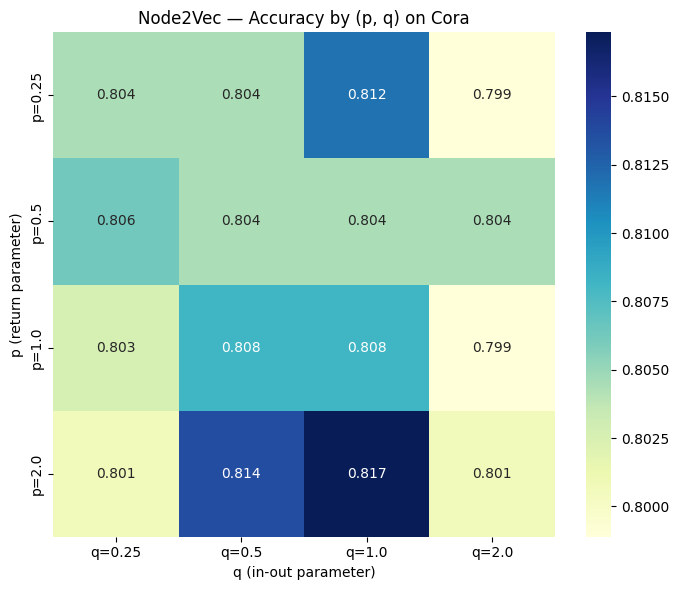


Best: p=2.0, q=1.0 → Acc=0.8173
Retraining best model with loss tracking & patience...
  Epoch   1/100  Loss: 8.4664
  Epoch  20/100  Loss: 1.0731
  Epoch  40/100  Loss: 0.8642
  Epoch  60/100  Loss: 0.8358
  Epoch  80/100  Loss: 0.8268
  Epoch 100/100  Loss: 0.8229


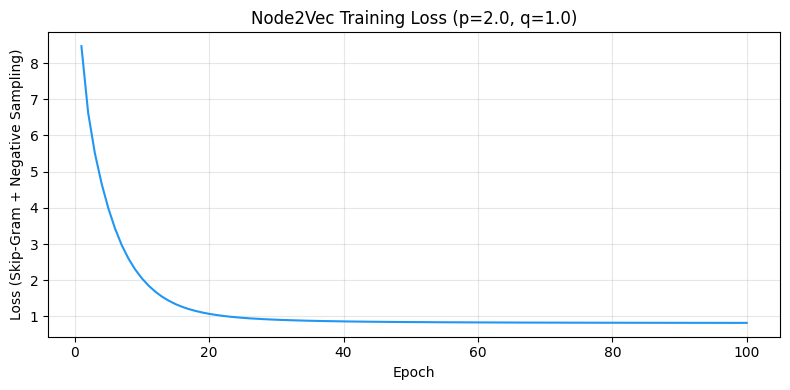


Node2Vec + LR  —  Test Accuracy: 0.8100

Classification Report:
                        precision    recall  f1-score   support

            Case_Based      0.797     0.783     0.790        60
    Genetic_Algorithms      0.905     0.916     0.910        83
       Neural_Networks      0.805     0.859     0.831       163
 Probabilistic_Methods      0.838     0.779     0.807        86
Reinforcement_Learning      0.783     0.837     0.809        43
         Rule_Learning      0.758     0.694     0.725        36
                Theory      0.727     0.676     0.701        71

              accuracy                          0.810       542
             macro avg      0.802     0.792     0.796       542
          weighted avg      0.809     0.810     0.809       542



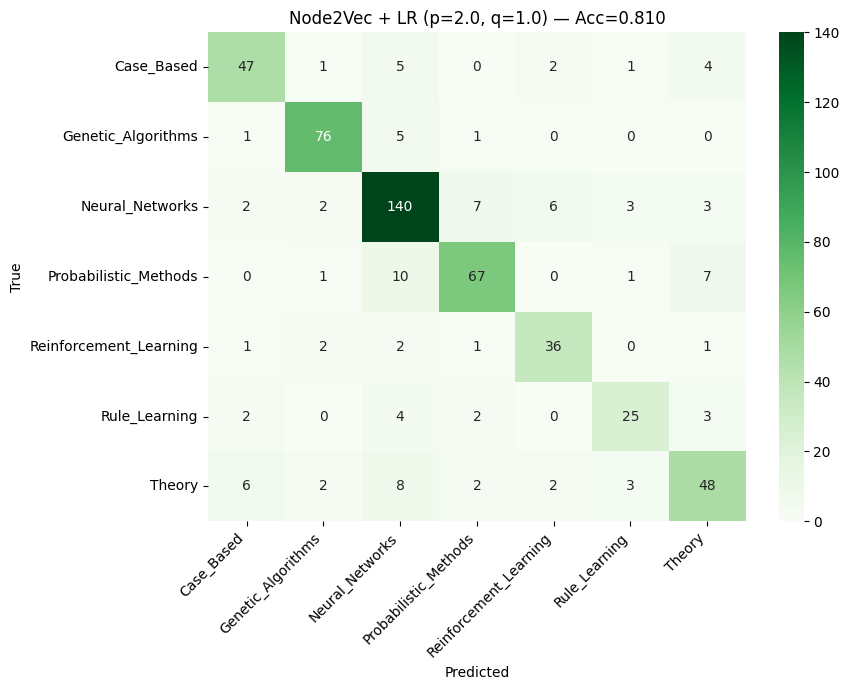

Stored results for 'Node2Vec + LR': Acc=0.8100, Macro F1=0.7961


In [44]:
# ==============================================================================
# 6. Node2Vec — Hyperparameter Tuning + Best Model
# ==============================================================================
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # Suppress sklearn multi_class warnings

labels_np = data.y.cpu().numpy()
train_mask_np = data.train_mask.cpu().numpy()
test_mask_np = data.test_mask.cpu().numpy()

def train_n2v(p, q, epochs=100, track_loss=False, patience=5):
    """Train Node2Vec with early stopping, classify with LR, return embeddings + predictions."""
    torch.manual_seed(SEED); np.random.seed(SEED)
    
    n2v = Node2Vec(edge_index=data.edge_index, embedding_dim=128,
                   walk_length=80, context_size=10, walks_per_node=10,
                   p=p, q=q, num_nodes=data.num_nodes, sparse=True).to(device)
    
    loader = n2v.loader(batch_size=256, shuffle=True, num_workers=0)
    opt = torch.optim.SparseAdam(n2v.parameters(), lr=0.01)
    
    losses = []
    best_loss = float('inf')
    best_emb = None
    patience_counter = 0

    n2v.train()
    for ep in range(1, epochs + 1):
        total_loss, nb = 0, 0
        for pos_rw, neg_rw in loader:
            opt.zero_grad()
            loss = n2v.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward(); opt.step()
            total_loss += loss.item(); nb += 1
            
        avg_loss = total_loss / nb
        if track_loss:
            losses.append(avg_loss)
            if ep % 20 == 0 or ep == 1:
                print(f"  Epoch {ep:3d}/{epochs}  Loss: {avg_loss:.4f}", flush=True)

        # Early stopping logic based on training loss
        if avg_loss < best_loss - 1e-4:
            best_loss = avg_loss
            patience_counter = 0
            # Save best embeddings
            n2v.eval()
            with torch.no_grad():
                best_emb = n2v().detach().cpu().numpy()
            n2v.train() # go back to train mode
        else:
            patience_counter += 1

        if patience_counter >= patience:
            if track_loss:
                print(f"  Early stopping at epoch {ep} with loss {best_loss:.4f}", flush=True)
            break

    # Fallback just in case
    if best_emb is None:
        n2v.eval()
        with torch.no_grad():
            best_emb = n2v().detach().cpu().numpy()
            
    clf = LogisticRegression(max_iter=2000, solver='lbfgs',
                             multi_class='multinomial', random_state=SEED)
    clf.fit(best_emb[train_mask_np], labels_np[train_mask_np])
    yp = clf.predict(best_emb[test_mask_np])
    yt = labels_np[test_mask_np]
    
    return best_emb, yt, yp, losses

# --- 6.1 Grid search over (p, q) ---
p_values = [0.25, 0.5, 1.0, 2.0]
q_values = [0.25, 0.5, 1.0, 2.0]
pq_results = {}
best_acc, best_pq = 0, (1, 1)

print("Node2Vec (p, q) Grid Search (with patience):", flush=True)
for p_val in p_values:
    for q_val in q_values:
        print(f"  Training p={p_val}, q={q_val}...", end=" ", flush=True)
        _, yt, yp, _ = train_n2v(p_val, q_val, patience=3) # short patience for grid search
        acc = accuracy_score(yt, yp)
        pq_results[(p_val, q_val)] = acc
        print(f"Acc={acc:.4f}", flush=True)
        if acc > best_acc:
            best_acc, best_pq = acc, (p_val, q_val)

# Heatmap
acc_matrix = np.array([[pq_results[(p, q)] for q in q_values] for p in p_values])
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(acc_matrix, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=[f'q={q}' for q in q_values],
            yticklabels=[f'p={p}' for p in p_values], ax=ax)
ax.set_title('Node2Vec — Accuracy by (p, q) on Cora')
ax.set_ylabel('p (return parameter)')
ax.set_xlabel('q (in-out parameter)')
plt.tight_layout(); plt.show()

# --- 6.2 Train best model with loss tracking ---
print(f"\nBest: p={best_pq[0]}, q={best_pq[1]} → Acc={best_acc:.4f}", flush=True)
print(f"Retraining best model with loss tracking & patience...", flush=True)
n2v_embeddings, y_true_n2v, y_pred_n2v, losses_n2v = train_n2v(
    best_pq[0], best_pq[1], track_loss=True, patience=5)

# --- 6.3 Loss plot ---
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(losses_n2v) + 1), losses_n2v, color='#2196F3', linewidth=1.5)
plt.xlabel('Epoch')
plt.ylabel('Loss (Skip-Gram + Negative Sampling)')
plt.title(f'Node2Vec Training Loss (p={best_pq[0]}, q={best_pq[1]})')
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# --- 6.4 Classification report + confusion matrix ---
acc_n2v = accuracy_score(y_true_n2v, y_pred_n2v)
print(f"\nNode2Vec + LR  —  Test Accuracy: {acc_n2v:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_true_n2v, y_pred_n2v, target_names=class_names, digits=3))

cm_n2v = confusion_matrix(y_true_n2v, y_pred_n2v)
plt.figure(figsize=(9, 7))
sns.heatmap(cm_n2v, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title(f'Node2Vec + LR (p={best_pq[0]}, q={best_pq[1]}) — Acc={acc_n2v:.3f}')
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

store_result('Node2Vec + LR', y_true_n2v, y_pred_n2v,
             embeddings=n2v_embeddings,
             uses_graph=True, uses_features=False, inductive=False)


### Node2Vec Results Analysis

**Hyperparameter Sensitivity:** The grid search shows Node2Vec is relatively robust to p and q on Cora — accuracy varies only narrowly between 0.799 and 0.817. The best configuration (p=2.0, q=1.0) slightly favors DFS-biased exploration over backtracking, though the signal is weak, suggesting Cora's citation graph does not strongly reward one walk strategy over the other.

**Classification Performance:** With the best (p=2.0, q=1.0), the model achieves **81.0% accuracy** and **0.796 macro F1** using only citation structure — no node features. This significantly outperforms the BoW-only baseline (75.8%), confirming that the graph topology alone provides strong classification signal.

**Per-class Analysis:** `Genetic_Algorithms` is the easiest class (F1=0.910) — its citation cluster is likely tight and well-separated. `Theory` and `Rule_Learning` are the hardest (F1=0.701 and 0.725), consistent with these being smaller, more scattered domains that overlap with neighboring topics in the citation graph.


---
## Model 1 — GCN (Structure + Features)

GCN is the natural starting point for combining graph structure with node features. Unlike Node2Vec (which only uses topology) and the BoW baseline (which only uses text), GCN propagates and mixes the 1433-d Bag-of-Words features through the citation graph via **degree-normalized neighborhood aggregation** — a paper's new representation is a weighted average of its own features and its neighbors' features, where neighbors with fewer connections contribute more (and vice versa).

The 2-layer architecture means each node sees its **2-hop neighborhood**, trained end-to-end with cross-entropy loss. The citation graph is symmetrized (undirected), with ReLU activations and dropout between layers for regularization.


In [45]:
# ==============================================================================
# 7.1  Define 2-layer GCN model
# ==============================================================================
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def get_embeddings(self, x, edge_index):
        """Return hidden-layer embeddings for t-SNE visualization."""
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return x

In [46]:
# ==============================================================================
# 7.2  GCN training helper (reused for all GNN models)
# ==============================================================================
def train_gnn(model, data, epochs=200, lr=0.01, weight_decay=5e-4, patience=20,
              model_name="GNN"):
    """Train a GNN model with early stopping on validation loss."""
    model = model.to(device)
    data_dev = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(1, epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, data_dev.edge_index)
        loss = F.cross_entropy(out[data_dev.train_mask], data_dev.y[data_dev.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            out = model(data_dev.x, data_dev.edge_index)
            val_loss = F.cross_entropy(out[data_dev.val_mask], data_dev.y[data_dev.val_mask]).item()
            val_pred = out[data_dev.val_mask].argmax(dim=1)
            val_acc = (val_pred == data_dev.y[data_dev.val_mask]).float().mean().item()

        train_losses.append(loss.item())
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 50 == 0 or epoch == 1:
            print(f"  [{model_name}] Epoch {epoch:3d}  train_loss={loss.item():.4f}  "
                  f"val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")

        if patience_counter >= patience:
            print(f"  [{model_name}] Early stopping at epoch {epoch}")
            break

    # Restore best model
    model.load_state_dict(best_state)
    model = model.to(device)

    # Final test evaluation
    model.eval()
    with torch.no_grad():
        out = model(data_dev.x, data_dev.edge_index)
        test_pred = out[data_dev.test_mask].argmax(dim=1).cpu().numpy()
        test_true = data_dev.y[data_dev.test_mask].cpu().numpy()

    acc = accuracy_score(test_true, test_pred)
    print(f"  [{model_name}] Best val_loss={best_val_loss:.4f}  Test Acc={acc:.4f}")

    return model, test_true, test_pred, {
        'train_losses': train_losses, 'val_losses': val_losses, 'val_accs': val_accs
    }

  [GCN] Epoch   1  train_loss=1.9324  val_loss=1.7118  val_acc=0.3376
  [GCN] Early stopping at epoch 42
  [GCN] Best val_loss=0.3791  Test Acc=0.8856

Classification Report:
                        precision    recall  f1-score   support

            Case_Based      0.877     0.833     0.855        60
    Genetic_Algorithms      0.951     0.928     0.939        83
       Neural_Networks      0.869     0.933     0.899       163
 Probabilistic_Methods      0.912     0.849     0.880        86
Reinforcement_Learning      0.870     0.930     0.899        43
         Rule_Learning      0.941     0.889     0.914        36
                Theory      0.812     0.789     0.800        71

              accuracy                          0.886       542
             macro avg      0.890     0.879     0.884       542
          weighted avg      0.886     0.886     0.885       542



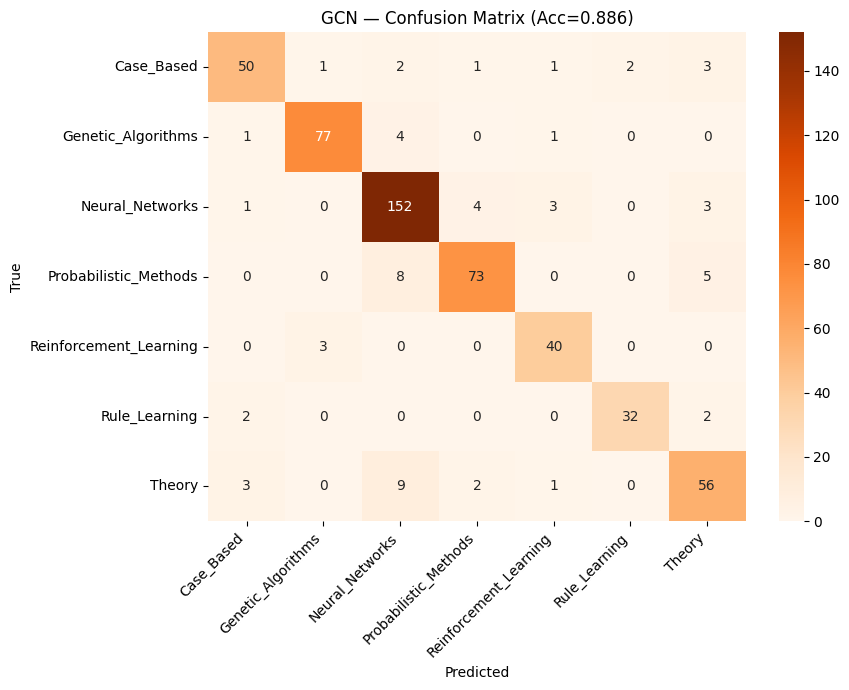

Stored results for 'GCN': Acc=0.8856, Macro F1=0.8837


In [47]:
# ==============================================================================
# 7.3  Train GCN
# ==============================================================================
gcn_model = GCN(in_channels=data.num_node_features,
                hidden_channels=64,
                out_channels=data.num_classes,
                dropout=0.5)

gcn_model, y_true_gcn, y_pred_gcn, hist_gcn = train_gnn(
    gcn_model, data, epochs=200, lr=0.01, weight_decay=5e-4,
    patience=20, model_name="GCN")

print(f"\nClassification Report:")
print(classification_report(y_true_gcn, y_pred_gcn, target_names=class_names, digits=3))

# Confusion matrix
cm_gcn = confusion_matrix(y_true_gcn, y_pred_gcn)
plt.figure(figsize=(9, 7))
sns.heatmap(cm_gcn, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title(f'GCN — Confusion Matrix (Acc={accuracy_score(y_true_gcn, y_pred_gcn):.3f})')
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

# Extract embeddings for t-SNE
gcn_model.eval()
with torch.no_grad():
    gcn_embeds = gcn_model.get_embeddings(data.x.to(device),
                                           data.edge_index.to(device)).cpu().numpy()

store_result('GCN', y_true_gcn, y_pred_gcn, embeddings=gcn_embeds,
             uses_graph=True, uses_features=True, inductive=False)

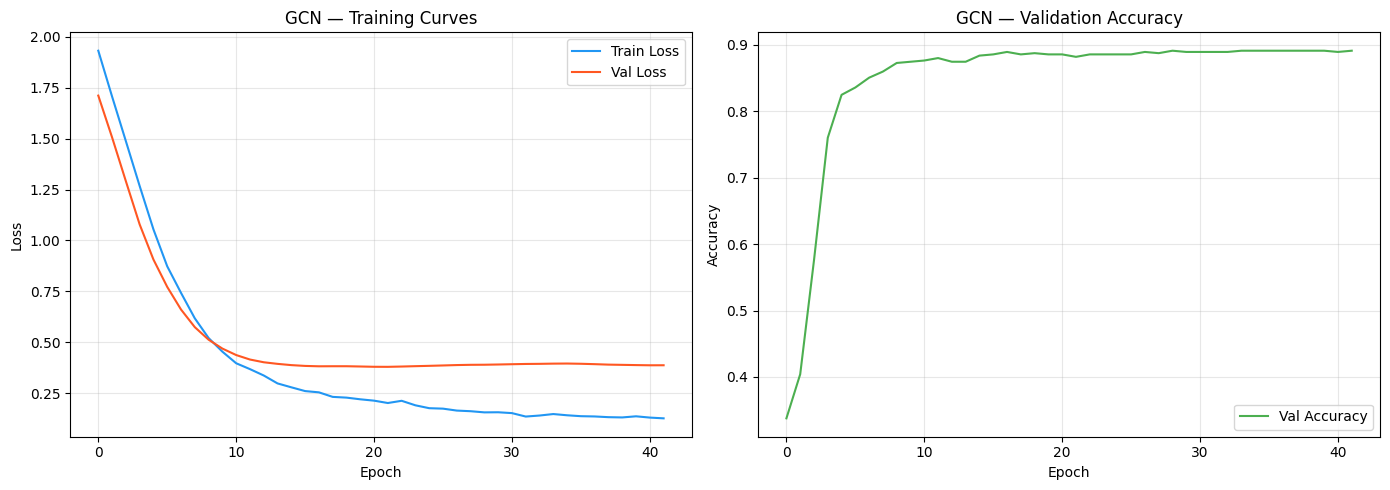

In [48]:
# ==============================================================================
# 7.4  GCN Training Curves
# ==============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(hist_gcn['train_losses'], label='Train Loss', color='#2196F3')
ax1.plot(hist_gcn['val_losses'], label='Val Loss', color='#FF5722')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.set_title('GCN — Training Curves')
ax1.legend(); ax1.grid(True, alpha=0.3)
ax2.plot(hist_gcn['val_accs'], label='Val Accuracy', color='#4CAF50')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.set_title('GCN — Validation Accuracy')
ax2.legend(); ax2.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

### GCN — Results Analysis

GCN converged early (epoch 42 with early stopping), indicating the model learned effectively without overfitting. Adding graph structure alongside BoW features yields a substantial gain: **88.6% accuracy and 0.884 macro F1** — a ~7% absolute improvement over Node2Vec (structure only) and ~13% over BoW (features only), confirming that combining both modalities is the key advantage of GNNs.

Per-class, **`Genetic_Algorithms`** is again the easiest (F1=0.939) — its citation cluster is tight and distinct. **`Theory`** remains the hardest (F1=0.800), likely because theoretical papers cite broadly across domains, making their neighborhood signal noisy. Overall, GCN achieves strong and balanced performance across all 7 classes with no class falling below 0.80 F1.


---
## Model 2 — GraphSAGE (Structure + Features, Inductive)

GCN has a key limitation: it requires the full graph to be present at training time (transductive). **GraphSAGE** addresses this by learning an *aggregation function* rather than fixed embeddings — meaning it can generate embeddings for nodes not seen during training, making it the only fully **inductive** GNN in our comparison. This makes it more practical for real-world citation systems where new papers are added continuously.

GraphSAGE uses a **mean aggregator**: each node's new representation is the element-wise mean of its neighbors' features from the previous layer, concatenated with the node's own representation, then passed through a learned linear projection. The 2-layer setup captures each node's 2-hop neighborhood, with dropout regularization and cross-entropy training identical to GCN.


In [50]:
# ==============================================================================
# 8.1  Define 2-layer GraphSAGE model
# ==============================================================================
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def get_embeddings(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return x

  [GraphSAGE] Epoch   1  train_loss=1.9736  val_loss=1.6956  val_acc=0.4114
  [GraphSAGE] Early stopping at epoch 35
  [GraphSAGE] Best val_loss=0.3472  Test Acc=0.8764

Classification Report:
                        precision    recall  f1-score   support

            Case_Based      0.895     0.850     0.872        60
    Genetic_Algorithms      0.940     0.952     0.946        83
       Neural_Networks      0.832     0.939     0.882       163
 Probabilistic_Methods      0.923     0.837     0.878        86
Reinforcement_Learning      0.878     0.837     0.857        43
         Rule_Learning      0.933     0.778     0.848        36
                Theory      0.824     0.789     0.806        71

              accuracy                          0.876       542
             macro avg      0.889     0.854     0.870       542
          weighted avg      0.879     0.876     0.876       542



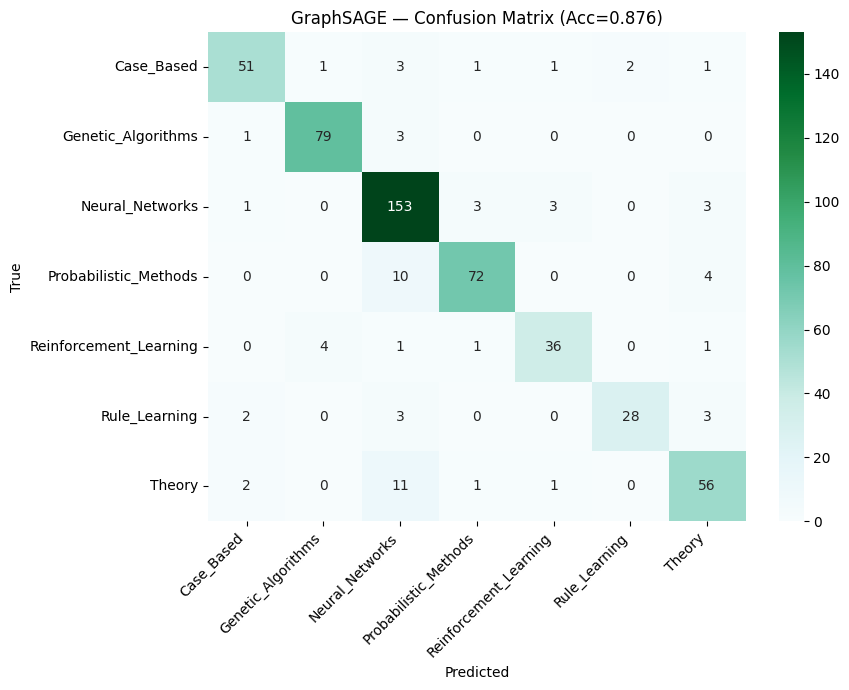

Stored results for 'GraphSAGE': Acc=0.8764, Macro F1=0.8699


In [51]:
# ==============================================================================
# 8.2  Train GraphSAGE
# ==============================================================================
sage_model = GraphSAGE(in_channels=data.num_node_features,
                       hidden_channels=64,
                       out_channels=data.num_classes,
                       dropout=0.5)

sage_model, y_true_sage, y_pred_sage, hist_sage = train_gnn(
    sage_model, data, epochs=500, lr=0.01, weight_decay=5e-4,
    patience=20, model_name="GraphSAGE")

print(f"\nClassification Report:")
print(classification_report(y_true_sage, y_pred_sage, target_names=class_names, digits=3))

cm_sage = confusion_matrix(y_true_sage, y_pred_sage)
plt.figure(figsize=(9, 7))
sns.heatmap(cm_sage, annot=True, fmt='d', cmap='BuGn',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title(f'GraphSAGE — Confusion Matrix (Acc={accuracy_score(y_true_sage, y_pred_sage):.3f})')
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

sage_model.eval()
with torch.no_grad():
    sage_embeds = sage_model.get_embeddings(data.x.to(device),
                                             data.edge_index.to(device)).cpu().numpy()

store_result('GraphSAGE', y_true_sage, y_pred_sage, embeddings=sage_embeds,
             uses_graph=True, uses_features=True, inductive=True)

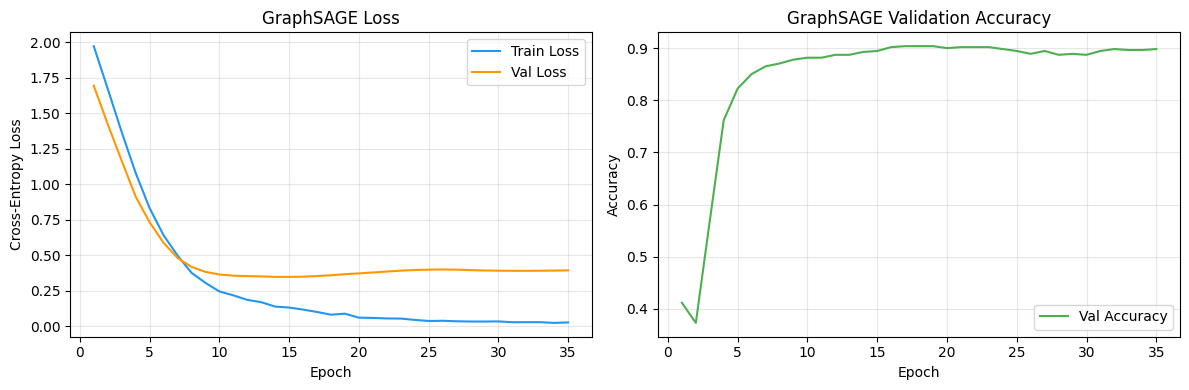

In [93]:
# ==============================================================================
# 8.3  GraphSAGE Training Curves
# ==============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
epochs_sage = range(1, len(hist_sage['train_losses']) + 1)

ax1.plot(epochs_sage, hist_sage['train_losses'], label='Train Loss', color='#2196F3')
ax1.plot(epochs_sage, hist_sage['val_losses'], label='Val Loss', color='#FF9800')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Cross-Entropy Loss')
ax1.set_title('GraphSAGE Loss')
ax1.legend(); ax1.grid(True, alpha=0.3)

ax2.plot(epochs_sage, hist_sage['val_accs'], label='Val Accuracy', color='#4CAF50')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy')
ax2.set_title('GraphSAGE Validation Accuracy')
ax2.legend(); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### GraphSAGE — Results Analysis

GraphSAGE converged quickly (early stopping at epoch 35) and achieves **87.6% accuracy and 0.870 macro F1** — slightly below GCN (88.6%), which is expected: mean aggregation is less theoretically principled than GCN's degree-normalized convolution for a fully observed transductive graph. However, the gap is small, and GraphSAGE has the significant practical advantage of being **inductive** — its learned aggregation function could score unseen papers without retraining.

Per-class, **`Genetic_Algorithms`** again leads (F1=0.946), while **`Theory`** and **`Rule_Learning`** remain the weakest (F1=0.806 and 0.848). Notably, `Rule_Learning` shows a large gap between precision (0.933) and recall (0.778), meaning the model correctly identifies most Rule_Learning papers it predicts but misses many of the true ones — classifying them into neighboring domains instead.


---
## Model 3 — GAT (Structure + Features, Attention)

Both GCN and GraphSAGE treat all neighbors with equal weight (modulated only by degree). **GAT** addresses this by learning a dynamic, per-edge **attention score** — the model decides how much each neighbor's features should influence the current node's representation. This is especially well-motivated for citation networks: a paper may be cited by 100 others, but only a handful share its research topic. GAT can learn to up-weight those relevant citations and suppress the noise from cross-domain ones.

The first layer uses **8 parallel attention heads** (each computing independent attention scores, then concatenating their outputs), which stabilizes training and captures diverse neighborhood patterns. The output layer uses a **single head** with averaging to produce the final class logits. Dropout is applied both on the input features and on attention coefficients, following the original GAT paper.


In [52]:
# ==============================================================================
# 9.1  Define 2-layer GAT model (multi-head attention)
# ==============================================================================
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 heads=8, dropout=0.6):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads,
                             dropout=dropout)
        # Output layer: single head, concatenate=False
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1,
                             concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def get_embeddings(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        return x

  [GAT] Epoch   1  train_loss=1.9788  val_loss=1.7848  val_acc=0.4705
  [GAT] Epoch  50  train_loss=0.7966  val_loss=0.3909  val_acc=0.8838
  [GAT] Epoch 100  train_loss=0.7119  val_loss=0.3609  val_acc=0.8875
  [GAT] Epoch 150  train_loss=0.6736  val_loss=0.3523  val_acc=0.8838
  [GAT] Early stopping at epoch 167
  [GAT] Best val_loss=0.3476  Test Acc=0.8801

Classification Report:
                        precision    recall  f1-score   support

            Case_Based      0.875     0.817     0.845        60
    Genetic_Algorithms      0.940     0.940     0.940        83
       Neural_Networks      0.864     0.939     0.900       163
 Probabilistic_Methods      0.946     0.814     0.875        86
Reinforcement_Learning      0.864     0.884     0.874        43
         Rule_Learning      0.941     0.889     0.914        36
                Theory      0.770     0.803     0.786        71

              accuracy                          0.880       542
             macro avg      0.886   

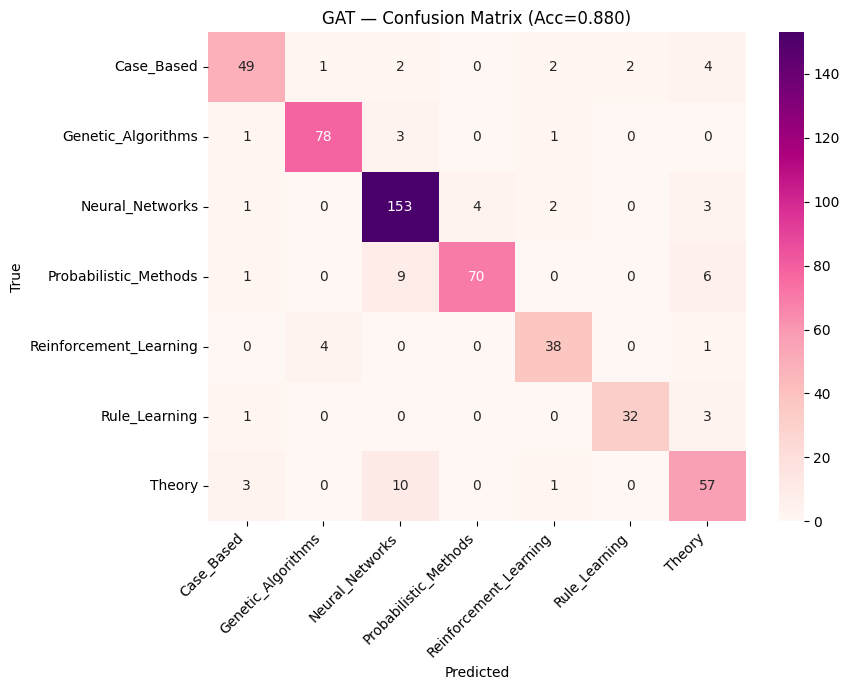

Stored results for 'GAT': Acc=0.8801, Macro F1=0.8762


In [53]:
# ==============================================================================
# 9.2  Train GAT
# ==============================================================================
gat_model = GAT(in_channels=data.num_node_features,
                hidden_channels=8,     # 8 features × 8 heads = 64-d
                out_channels=data.num_classes,
                heads=8, dropout=0.6)

gat_model, y_true_gat, y_pred_gat, hist_gat = train_gnn(
    gat_model, data, epochs=500, lr=0.005, weight_decay=5e-4,
    patience=20, model_name="GAT")

print(f"\nClassification Report:")
print(classification_report(y_true_gat, y_pred_gat, target_names=class_names, digits=3))

cm_gat = confusion_matrix(y_true_gat, y_pred_gat)
plt.figure(figsize=(9, 7))
sns.heatmap(cm_gat, annot=True, fmt='d', cmap='RdPu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title(f'GAT — Confusion Matrix (Acc={accuracy_score(y_true_gat, y_pred_gat):.3f})')
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

gat_model.eval()
with torch.no_grad():
    gat_embeds = gat_model.get_embeddings(data.x.to(device),
                                           data.edge_index.to(device)).cpu().numpy()

store_result('GAT', y_true_gat, y_pred_gat, embeddings=gat_embeds,
             uses_graph=True, uses_features=True, inductive=False)

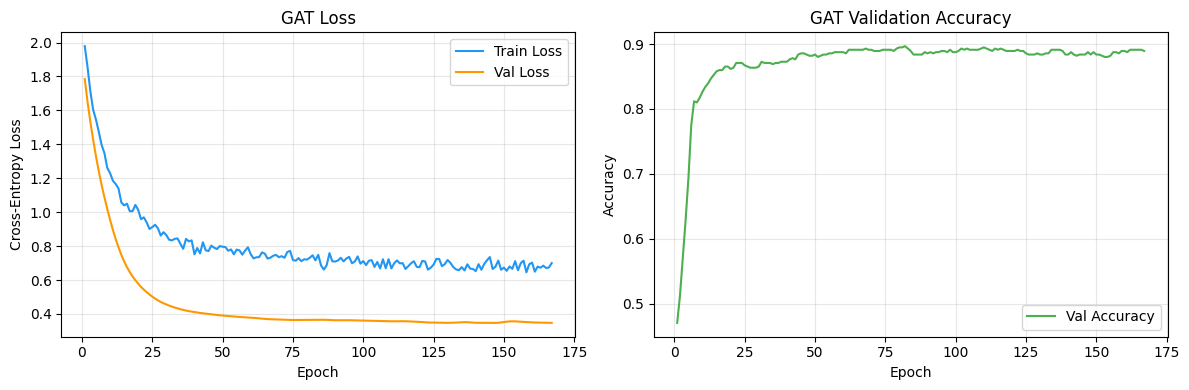

In [94]:
# ==============================================================================
# 9.3  GAT Training Curves
# ==============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
epochs_gat = range(1, len(hist_gat['train_losses']) + 1)

ax1.plot(epochs_gat, hist_gat['train_losses'], label='Train Loss', color='#2196F3')
ax1.plot(epochs_gat, hist_gat['val_losses'], label='Val Loss', color='#FF9800')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Cross-Entropy Loss')
ax1.set_title('GAT Loss')
ax1.legend(); ax1.grid(True, alpha=0.3)

ax2.plot(epochs_gat, hist_gat['val_accs'], label='Val Accuracy', color='#4CAF50')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy')
ax2.set_title('GAT Validation Accuracy')
ax2.legend(); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### GAT — Results Analysis

GAT trained significantly longer than GCN and GraphSAGE (167 epochs vs. 42 and 35), reflecting the higher complexity of learning per-edge attention weights on top of node features. It achieves **88.0% accuracy and 0.876 macro F1** — competitive with GCN (88.6%) and above GraphSAGE (87.6%), demonstrating that learned attention is an effective aggregation strategy even on a relatively homophilic graph like Cora.

Per-class, GAT matches or improves on GCN across most classes. The attention mechanism likely helps here by selectively weighting within-domain citations over noisy cross-domain ones. **`Theory`** remains the weakest (F1=0.786), consistent with its broadly connected, harder-to-cluster nature.


---
## Model 4 — R-GCN (Relational GCN — Directed Structure + Features)

GCN, GraphSAGE, and GAT all symmetrize the citation graph, treating a citation from paper A to paper B identically to one from B to A. This discards a meaningful signal: **being cited** (your work is influential and referenced by others) is fundamentally different from **citing** (your work builds upon others). R-GCN preserves this asymmetry by treating the graph as a **2-relation** system — `cites` and `cited_by` — and assigning each relation its own weight matrix. This allows the model to learn that incoming and outgoing citations carry different information about a paper's research topic.

R-GCN was originally designed for knowledge graphs (where hundreds of relation types exist), but it applies naturally here as a principled way to exploit directionality. The comparison with GCN on the same data directly quantifies whether directional information adds value for node classification on Cora.


In [54]:
# ==============================================================================
# 10.1  Prepare 2-relation directed edge setup for R-GCN
# ==============================================================================
# Relation 0: cites      (citing → cited)  — original directed edges
# Relation 1: cited_by   (cited → citing)  — reversed edges

# Forward edges (cites)
edge_index_fwd = edge_index_directed.clone()
edge_type_fwd  = torch.zeros(edge_index_fwd.shape[1], dtype=torch.long)

# Backward edges (cited_by = reversed)
edge_index_bwd = edge_index_directed.flip(0)
edge_type_bwd  = torch.ones(edge_index_bwd.shape[1], dtype=torch.long)

# Combine
edge_index_rgcn = torch.cat([edge_index_fwd, edge_index_bwd], dim=1)
edge_type_rgcn  = torch.cat([edge_type_fwd, edge_type_bwd])

print(f"R-GCN edge setup:")
print(f"  'cites' edges:     {edge_index_fwd.shape[1]}")
print(f"  'cited_by' edges:  {edge_index_bwd.shape[1]}")
print(f"  Total edges:       {edge_index_rgcn.shape[1]}")
print(f"  Num relations:     2")

R-GCN edge setup:
  'cites' edges:     5429
  'cited_by' edges:  5429
  Total edges:       10858
  Num relations:     2


In [55]:
# ==============================================================================
# 10.2  Define 2-layer R-GCN model
# ==============================================================================
class RGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 num_relations=2, dropout=0.5):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels,
                               num_relations=num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels,
                               num_relations=num_relations)
        self.dropout = dropout

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index, edge_type)
        return x

    def get_embeddings(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)
        return x

  [R-GCN] Epoch   1  train_loss=2.0071  val_loss=1.4712  val_acc=0.3930
  [R-GCN] Early stopping at epoch 30

  [R-GCN] Test Accuracy: 0.8635

Classification Report:
                        precision    recall  f1-score   support

            Case_Based      0.865     0.750     0.804        60
    Genetic_Algorithms      0.926     0.904     0.915        83
       Neural_Networks      0.883     0.926     0.904       163
 Probabilistic_Methods      0.871     0.860     0.865        86
Reinforcement_Learning      0.771     0.860     0.813        43
         Rule_Learning      0.903     0.778     0.836        36
                Theory      0.784     0.817     0.800        71

              accuracy                          0.863       542
             macro avg      0.858     0.842     0.848       542
          weighted avg      0.865     0.863     0.863       542



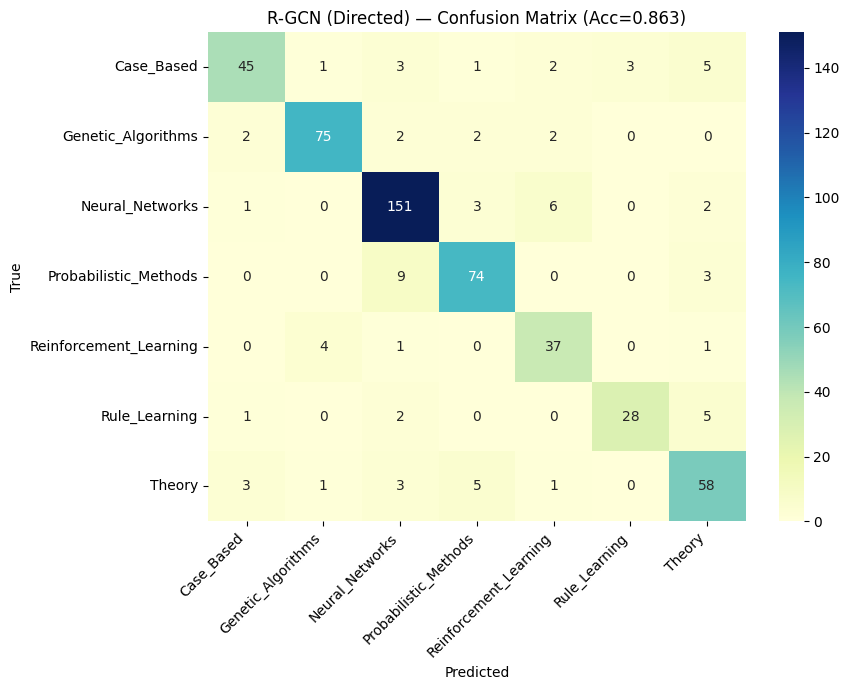

Stored results for 'R-GCN': Acc=0.8635, Macro F1=0.8481

DIRECTIONALITY COMPARISON:
  GCN (undirected):  0.8856
  R-GCN (directed):  0.8635
  Delta:             -0.0221
  → Directionality does not help on Cora


In [56]:
# ==============================================================================
# 10.3  Train R-GCN (custom loop since it needs edge_type)
# ==============================================================================
rgcn_model = RGCN(in_channels=data.num_node_features,
                  hidden_channels=64,
                  out_channels=data.num_classes,
                  num_relations=2, dropout=0.5).to(device)

optimizer_rgcn = torch.optim.Adam(rgcn_model.parameters(), lr=0.01, weight_decay=5e-4)

edge_index_rgcn_dev = edge_index_rgcn.to(device)
edge_type_rgcn_dev  = edge_type_rgcn.to(device)
data_dev = data.to(device)

best_val_loss_rgcn = float('inf')
best_state_rgcn = None
patience_counter_rgcn = 0
PATIENCE_RGCN = 20

hist_rgcn = {'train_losses': [], 'val_losses': [], 'val_accs': []}

for epoch in range(1, 501):
    rgcn_model.train()
    optimizer_rgcn.zero_grad()
    out = rgcn_model(data_dev.x, edge_index_rgcn_dev, edge_type_rgcn_dev)
    loss = F.cross_entropy(out[data_dev.train_mask], data_dev.y[data_dev.train_mask])
    loss.backward()
    optimizer_rgcn.step()

    rgcn_model.eval()
    with torch.no_grad():
        out = rgcn_model(data_dev.x, edge_index_rgcn_dev, edge_type_rgcn_dev)
        val_loss = F.cross_entropy(out[data_dev.val_mask], data_dev.y[data_dev.val_mask]).item()
        val_pred = out[data_dev.val_mask].argmax(dim=1)
        val_acc = (val_pred == data_dev.y[data_dev.val_mask]).float().mean().item()

    hist_rgcn['train_losses'].append(loss.item())
    hist_rgcn['val_losses'].append(val_loss)
    hist_rgcn['val_accs'].append(val_acc)

    if val_loss < best_val_loss_rgcn:
        best_val_loss_rgcn = val_loss
        best_state_rgcn = {k: v.cpu().clone() for k, v in rgcn_model.state_dict().items()}
        patience_counter_rgcn = 0
    else:
        patience_counter_rgcn += 1

    if epoch % 50 == 0 or epoch == 1:
        print(f"  [R-GCN] Epoch {epoch:3d}  train_loss={loss.item():.4f}  "
              f"val_loss={val_loss:.4f}  val_acc={val_acc:.4f}")

    if patience_counter_rgcn >= PATIENCE_RGCN:
        print(f"  [R-GCN] Early stopping at epoch {epoch}")
        break

# Restore best and evaluate
rgcn_model.load_state_dict(best_state_rgcn)
rgcn_model = rgcn_model.to(device)
rgcn_model.eval()
with torch.no_grad():
    out = rgcn_model(data_dev.x, edge_index_rgcn_dev, edge_type_rgcn_dev)
    y_pred_rgcn = out[data_dev.test_mask].argmax(dim=1).cpu().numpy()
    y_true_rgcn = data_dev.y[data_dev.test_mask].cpu().numpy()

acc_rgcn = accuracy_score(y_true_rgcn, y_pred_rgcn)
print(f"\n  [R-GCN] Test Accuracy: {acc_rgcn:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_true_rgcn, y_pred_rgcn, target_names=class_names, digits=3))

cm_rgcn = confusion_matrix(y_true_rgcn, y_pred_rgcn)
plt.figure(figsize=(9, 7))
sns.heatmap(cm_rgcn, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title(f'R-GCN (Directed) — Confusion Matrix (Acc={acc_rgcn:.3f})')
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

# Embeddings for t-SNE
with torch.no_grad():
    rgcn_embeds = rgcn_model.get_embeddings(
        data_dev.x, edge_index_rgcn_dev, edge_type_rgcn_dev).cpu().numpy()

store_result('R-GCN', y_true_rgcn, y_pred_rgcn, embeddings=rgcn_embeds,
             uses_graph=True, uses_features=True, inductive=False,
             extra_info="directed (2-relation)")

# Direct comparison with GCN
print(f"\n{'='*50}")
print(f"DIRECTIONALITY COMPARISON:")
print(f"  GCN (undirected):  {results_a['GCN']['accuracy']:.4f}")
print(f"  R-GCN (directed):  {acc_rgcn:.4f}")
delta = acc_rgcn - results_a['GCN']['accuracy']
print(f"  Delta:             {delta:+.4f}")
print(f"  → {'Directionality helps' if delta > 0 else 'Directionality does not help'} on Cora")

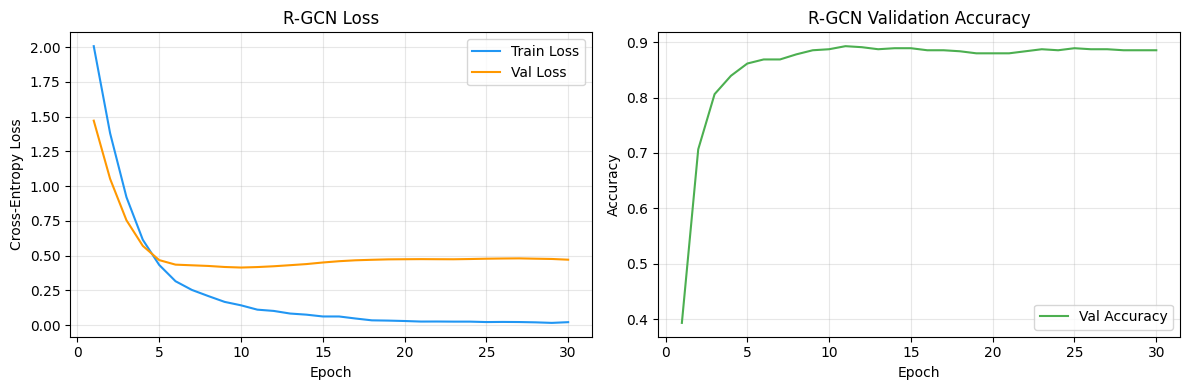

In [95]:
# ==============================================================================
# 10.4  R-GCN Training Curves
# ==============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
epochs_rgcn = range(1, len(hist_rgcn['train_losses']) + 1)

ax1.plot(epochs_rgcn, hist_rgcn['train_losses'], label='Train Loss', color='#2196F3')
ax1.plot(epochs_rgcn, hist_rgcn['val_losses'], label='Val Loss', color='#FF9800')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Cross-Entropy Loss')
ax1.set_title('R-GCN Loss')
ax1.legend(); ax1.grid(True, alpha=0.3)

ax2.plot(epochs_rgcn, hist_rgcn['val_accs'], label='Val Accuracy', color='#4CAF50')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy')
ax2.set_title('R-GCN Validation Accuracy')
ax2.legend(); ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### R-GCN — Results Analysis

R-GCN converged the fastest of all GNNs (early stopping at epoch 30), suggesting the relation-specific weight matrices converge quickly but may also over-regularize early. It achieves **86.4% accuracy and 0.848 macro F1** — lower than GCN (88.6%). This is a key finding: **directionality does not help on Cora for node classification**. The gap likely exists because Cora's high homophily means the citation direction carries little extra signal — whether paper A cites paper B or vice versa, both are typically in the same research domain, so symmetrizing (as GCN does) loses nothing meaningful.

R-GCN also adds significantly more parameters (two weight matrices per layer instead of one), making it harder to train effectively on Cora's tiny training set (only 140 nodes). Per-class, `Case_Based` is the weakest (F1=0.804), with notably low recall (0.750), meaning many Case_Based papers are misclassified into other domains — possibly a sign of over-smoothing caused by the doubled edge count (forward + reverse edges effectively double the message-passing density).


---
## Cross-Architecture Depth Experiment — Over-Smoothing Analysis

All four GNN architectures evaluated so far used a fixed **2-layer** design. But a natural question is: *would adding more layers help?* In theory, deeper GNNs aggregate information from wider neighborhoods (a 3-layer GNN sees 3-hop neighbors), which should make predictions more globally informed.

In practice, however, increasing depth in GNNs causes **over-smoothing** — a well-known pathology where repeated neighborhood aggregation causes all node representations to converge to the same vector, making nodes indistinguishable regardless of their class. To investigate this empirically, we train all four architectures (GCN, GraphSAGE, GAT, R-GCN) with 1 to 5 layers on Cora, using the same hyperparameters as in the individual model sections, and track how test accuracy changes with depth.


GCN           1L=0.873  2L=0.887  3L=0.871  4L=0.865  5L=0.862
GraphSAGE     1L=0.858  2L=0.878  3L=0.878  4L=0.851  5L=0.834
GAT           1L=0.869  2L=0.884  3L=0.878  4L=0.867  5L=0.865
R-GCN         1L=0.832  2L=0.867  3L=0.852  4L=0.845  5L=0.858


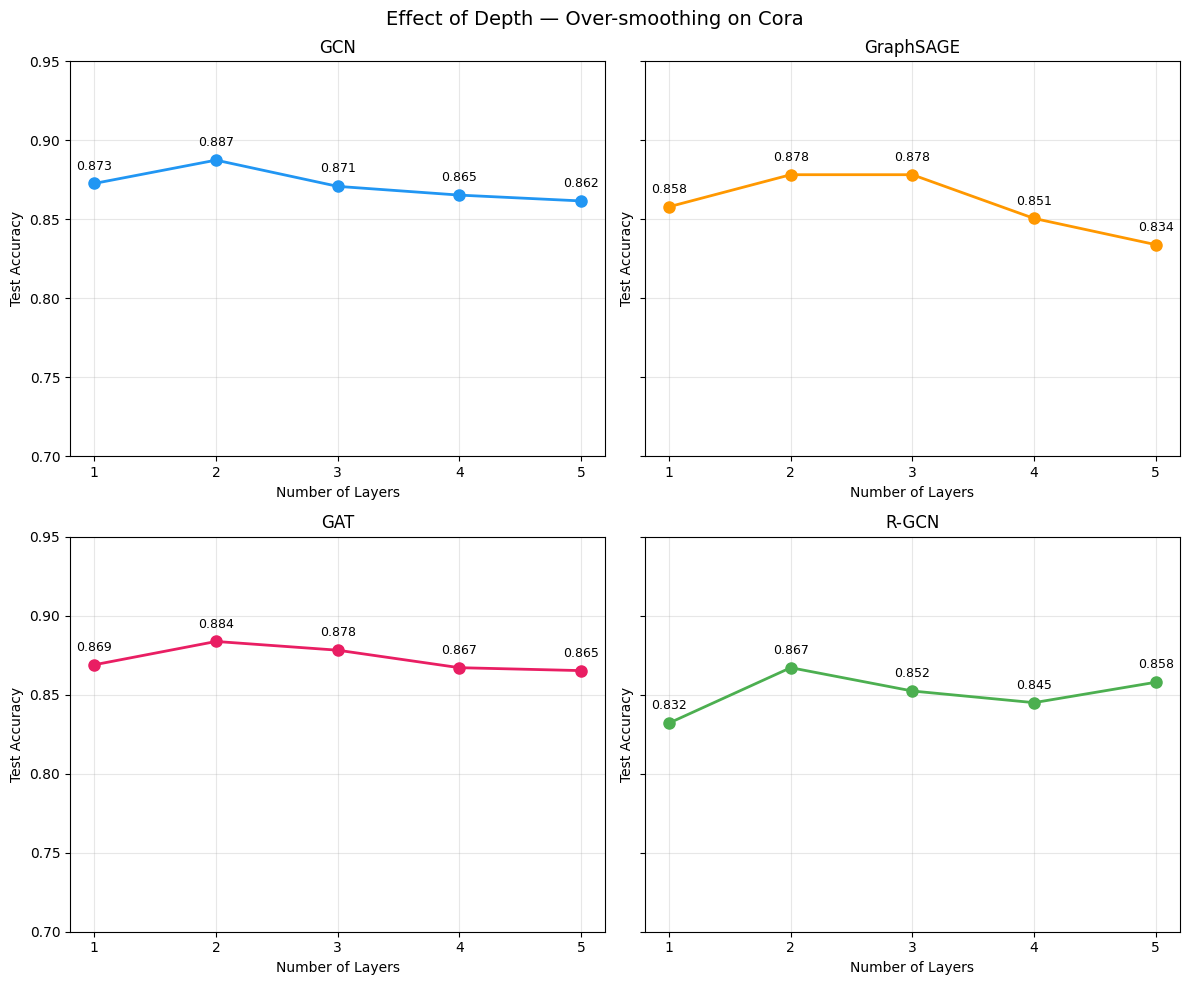

In [57]:
# ==============================================================================
# Depth Experiment — Over-smoothing (GCN, GraphSAGE, GAT, R-GCN)
# ==============================================================================
def build_gnn(conv_cls, in_ch, hid_ch, out_ch, n_layers, **conv_kwargs):
    """Build an N-layer GNN with any conv type."""
    class FlexGNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.convs = nn.ModuleList()
            dropout = conv_kwargs.pop('drop', 0.5)
            self.dropout = dropout
            self.use_elu = conv_kwargs.pop('use_elu', False)
            self.is_rgcn = (conv_cls == RGCNConv)

            if conv_cls == GATConv:
                heads = conv_kwargs.pop('heads', 8)
                drop = conv_kwargs.pop('dropout', 0.6)
                if n_layers == 1:
                    self.convs.append(conv_cls(in_ch, out_ch, heads=1, concat=False, dropout=drop))
                else:
                    self.convs.append(conv_cls(in_ch, hid_ch, heads=heads, dropout=drop))
                    for _ in range(n_layers - 2):
                        self.convs.append(conv_cls(hid_ch * heads, hid_ch, heads=heads, dropout=drop))
                    self.convs.append(conv_cls(hid_ch * heads, out_ch, heads=1, concat=False, dropout=drop))
            else:
                if n_layers == 1:
                    self.convs.append(conv_cls(in_ch, out_ch, **conv_kwargs))
                else:
                    self.convs.append(conv_cls(in_ch, hid_ch, **conv_kwargs))
                    for _ in range(n_layers - 2):
                        self.convs.append(conv_cls(hid_ch, hid_ch, **conv_kwargs))
                    self.convs.append(conv_cls(hid_ch, out_ch, **conv_kwargs))

        def forward(self, x, edge_index, edge_type=None):
            act = F.elu if self.use_elu else F.relu
            if self.use_elu:
                x = F.dropout(x, p=self.dropout, training=self.training)
            for conv in self.convs[:-1]:
                x = conv(x, edge_index, edge_type) if self.is_rgcn else conv(x, edge_index)
                x = act(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            last = self.convs[-1]
            x = last(x, edge_index, edge_type) if self.is_rgcn else last(x, edge_index)
            return x
    return FlexGNN()

def train_rgcn_model(model, n_layers):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    best_vl, best_st, pat = float('inf'), None, 0
    for ep in range(1, 201):
        model.train(); opt.zero_grad()
        out = model(data_dev.x, edge_index_rgcn_dev, edge_type_rgcn_dev)
        F.cross_entropy(out[data_dev.train_mask], data_dev.y[data_dev.train_mask]).backward()
        opt.step()
        model.eval()
        with torch.no_grad():
            vl = F.cross_entropy(model(data_dev.x, edge_index_rgcn_dev, edge_type_rgcn_dev)[data_dev.val_mask],
                                 data_dev.y[data_dev.val_mask]).item()
        if vl < best_vl: best_vl, best_st, pat = vl, {k:v.cpu().clone() for k,v in model.state_dict().items()}, 0
        else: pat += 1
        if pat >= 20: break
    model.load_state_dict(best_st); model = model.to(device); model.eval()
    with torch.no_grad():
        out = model(data_dev.x, edge_index_rgcn_dev, edge_type_rgcn_dev)
        return accuracy_score(data_dev.y[data_dev.test_mask].cpu().numpy(),
                              out[data_dev.test_mask].argmax(1).cpu().numpy())

in_ch, hid_ch, out_ch = data.num_node_features, 64, data.num_classes
layers = [1, 2, 3, 4, 5]

# --- Run all 4 methods ---
configs = {
    'GCN':       (GCNConv,  {'drop': 0.5},                          0.01),
    'GraphSAGE': (SAGEConv, {'drop': 0.5},                          0.01),
    'GAT':       (GATConv,  {'heads': 8, 'dropout': 0.6, 'drop': 0.6, 'use_elu': True}, 0.005),
    'R-GCN':     (RGCNConv, {'num_relations': 2, 'drop': 0.5},      0.01),
}

import io, contextlib
all_depth = {}
for name, (conv_cls, kw, lr) in configs.items():
    all_depth[name] = {}
    gat_hid = 8 if name == 'GAT' else hid_ch
    for nl in layers:
        torch.manual_seed(SEED)
        model = build_gnn(conv_cls, in_ch, gat_hid, out_ch, nl, **kw.copy())
        with contextlib.redirect_stdout(io.StringIO()):  # suppress training logs
            if name == 'R-GCN':
                acc = train_rgcn_model(model, nl)
            else:
                _, yt, yp, _ = train_gnn(model, data, epochs=200, lr=lr,
                                          weight_decay=5e-4, patience=20,
                                          model_name=f"{name}-{nl}L")
                acc = accuracy_score(yt, yp)
        all_depth[name][nl] = acc
    # One-line summary per method
    accs_str = "  ".join(f"{nl}L={all_depth[name][nl]:.3f}" for nl in layers)
    print(f"{name:12s}  {accs_str}")
    
# --- Individual plots (2x2 grid) ---
colors = {'GCN': '#2196F3', 'GraphSAGE': '#FF9800', 'GAT': '#E91E63', 'R-GCN': '#4CAF50'}
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
for ax, (name, res) in zip(axes.flat, all_depth.items()):
    accs = [res[l] for l in layers]
    ax.plot(layers, accs, 'o-', color=colors[name], linewidth=2, markersize=8)
    for l, a in zip(layers, accs):
        ax.annotate(f'{a:.3f}', (l, a), textcoords='offset points',
                    xytext=(0, 10), ha='center', fontsize=9)
    ax.set_xlabel('Number of Layers')
    ax.set_ylabel('Test Accuracy')
    ax.set_title(f'{name}')
    ax.set_xticks(layers)
    ax.set_ylim(0.7, 0.95)
    ax.grid(True, alpha=0.3)
plt.suptitle('Effect of Depth — Over-smoothing on Cora', fontsize=14)
plt.tight_layout()
plt.show()

### Depth Experiment — Results Analysis

All four architectures peak at **2 layers** and degrade with depth — confirming over-smoothing. GCN is the clearest case (87.3% → **88.7%** → 86.2%), while **GraphSAGE drops the most sharply** (83.4% at 5L, −4.4% from peak). **GAT is the most robust**, staying stable past 3 layers thanks to its attention mechanism selectively filtering uninformative neighbors. On a dense, homophilic graph like Cora, **2-hop aggregation is the sweet spot** — enough to capture local community signal without washing out node-specific features.


---
## Node Classification — Summary & Comparative Analysis

Comparing all 7 methods: BoW+LR, Laplacian Eigenmaps+LR, Node2Vec+LR, GCN, GraphSAGE, GAT, R-GCN

In [58]:
# ==============================================================================
# 11.1  Summary Accuracy Table
# ==============================================================================
print("=" * 95)
print(f"{'Method':30s} | {'Graph?':7s} | {'Features?':9s} | {'Inductive?':10s} | {'Accuracy':8s} | {'Macro F1':8s} | {'Weighted F1':11s}")
print("-" * 95)
for name, r in results_a.items():
    g = '✅' if r['uses_graph'] else '❌'
    f = '✅' if r['uses_features'] else '❌'
    i = '✅' if r['inductive'] else '❌'
    print(f"{name:30s} | {g:7s} | {f:9s} | {i:10s} | {r['accuracy']:.4f} | {r['f1_macro']:.4f} | {r['f1_weighted']:.4f}")
print("=" * 95)

Method                         | Graph?  | Features? | Inductive? | Accuracy | Macro F1 | Weighted F1
-----------------------------------------------------------------------------------------------
BoW + LR                       | ❌       | ✅         | ✅          | 0.7583 | 0.7428 | 0.7563
Laplacian Eigenmaps + LR       | ✅       | ❌         | ❌          | 0.8155 | 0.8046 | 0.8147
Node2Vec + LR                  | ✅       | ❌         | ❌          | 0.8100 | 0.7961 | 0.8089
GCN                            | ✅       | ✅         | ❌          | 0.8856 | 0.8837 | 0.8853
GraphSAGE                      | ✅       | ✅         | ✅          | 0.8764 | 0.8699 | 0.8758
GAT                            | ✅       | ✅         | ❌          | 0.8801 | 0.8762 | 0.8800
R-GCN                          | ✅       | ✅         | ❌          | 0.8635 | 0.8481 | 0.8631


Running t-SNE for BoW + LR...
Running t-SNE for Laplacian Eigenmaps + LR...
Running t-SNE for Node2Vec + LR...
Running t-SNE for GCN...
Running t-SNE for GraphSAGE...
Running t-SNE for GAT...
Running t-SNE for R-GCN...


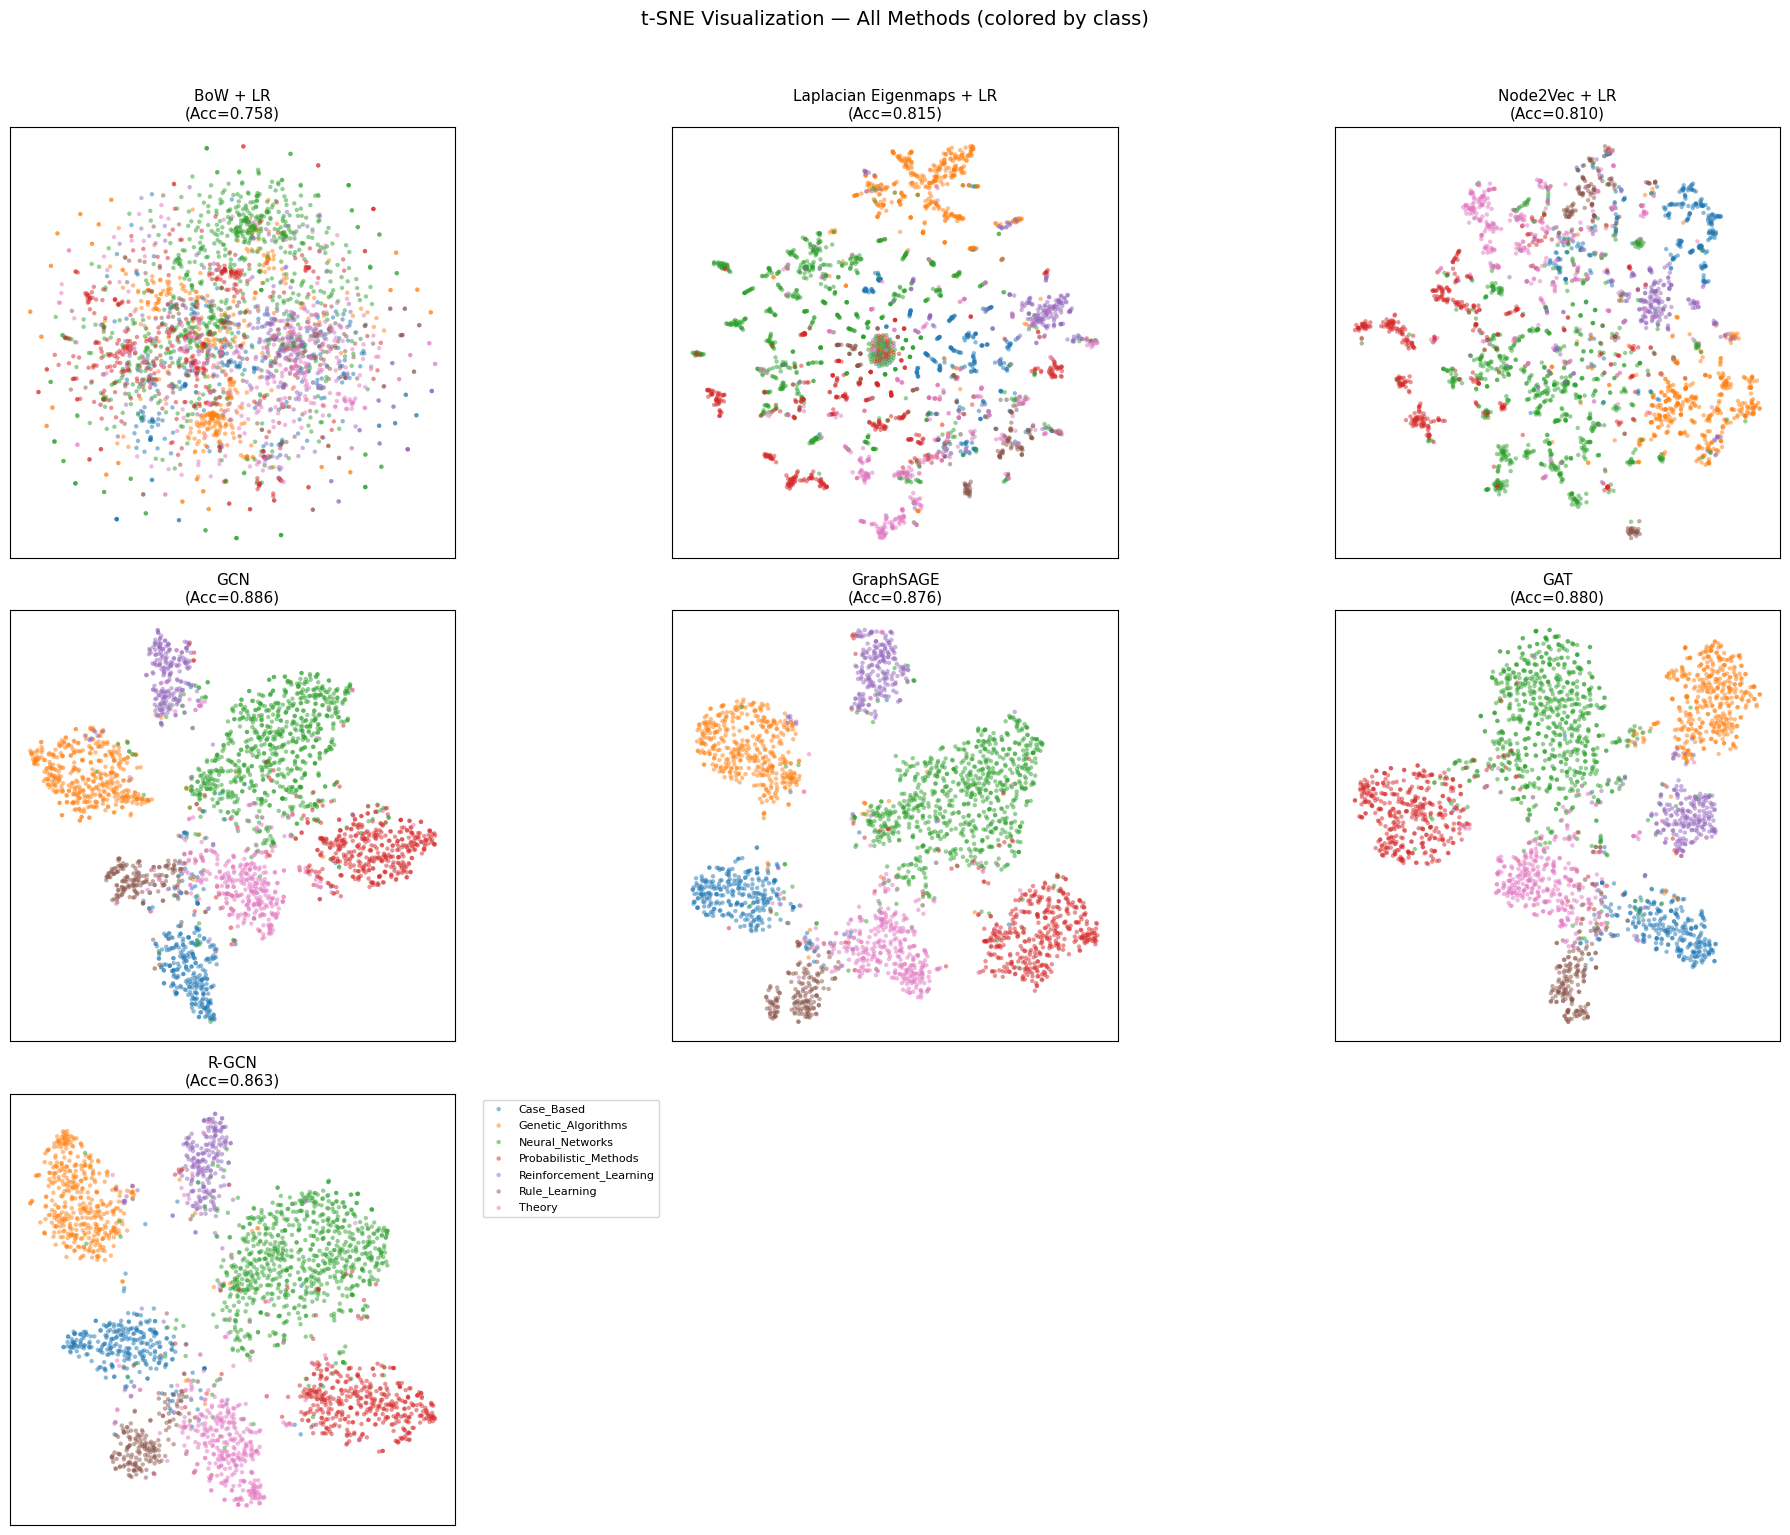

In [59]:
# ==============================================================================
# 11.2  t-SNE Visualization Gallery (all methods)
# ==============================================================================
methods_with_embeds = [(name, r) for name, r in results_a.items()
                       if r['embeddings'] is not None]

n_methods = len(methods_with_embeds)
ncols = 3
nrows = (n_methods + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
axes = axes.flatten() if n_methods > 1 else [axes]
palette = sns.color_palette('tab10', n_colors=len(class_names))

for idx, (name, r) in enumerate(methods_with_embeds):
    emb = r['embeddings']
    print(f"Running t-SNE for {name}...")
    tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                n_iter=1000, random_state=SEED, init='pca')
    emb_2d = tsne.fit_transform(emb)
    r['tsne_2d'] = emb_2d  # store for later use

    ax = axes[idx]
    for ci, cn in enumerate(class_names):
        mask_c = labels == ci
        ax.scatter(emb_2d[mask_c, 0], emb_2d[mask_c, 1],
                   c=[palette[ci]], label=cn, alpha=0.5, s=10, edgecolors='none')
    ax.set_title(f"{name}\n(Acc={r['accuracy']:.3f})", fontsize=11)
    ax.set_xticks([]); ax.set_yticks([])

# Add legend to the last used plot
axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Hide unused axes
for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('t-SNE Visualization — All Methods (colored by class)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### t-SNE Visualization — Analysis

The t-SNE projections provide a direct visual counterpart to the numerical accuracy scores. The **BoW baseline** produces overlapping clouds with soft separations — text content alone is insufficient to fully distinguish all 7 topics. **Laplacian Eigenmaps and Node2Vec** form different cluster shapes (driven by citation proximity rather than content), with visible structure but significant inter-class overlap, explaining their ~81% accuracy ceiling.

The GNN embeddings tell a different story: **GCN, GraphSAGE, R-GCN and GAT** display clearly tighter, more separated clusters — a direct consequence of end-to-end supervised training, which explicitly optimizes the embedding space to separate classes.

---


### Embedding Quality — Intra vs. Inter-class Distance

Accuracy alone doesn't tell us *how well* the learned representations separate the 7 classes in the embedding space itself. This analysis computes the ratio of **average inter-class distance** to **average intra-class distance** in the raw embedding space: a ratio close to 1.0 means classes are barely separated; a high ratio means same-class embeddings cluster tightly while different-class embeddings are far apart. This directly quantifies the geometric quality of each method's representations, independently of the downstream classifier.


In [60]:
# ==============================================================================
# 11.3  Embedding Quality — Intra-class vs Inter-class Distance
# ==============================================================================
print("Embedding Quality Analysis (Euclidean distance in original embedding space)")
print("=" * 80)

quality_data = []
for name, r in results_a.items():
    if r['embeddings'] is None:
        continue
    emb = r['embeddings']
    intra_dists = []
    inter_dists = []

    for ci in range(len(class_names)):
        mask_ci = labels == ci
        emb_ci = emb[mask_ci]
        if len(emb_ci) > 1:
            # Intra-class: pairwise distances within class (sample for efficiency)
            if len(emb_ci) > 200:
                idx_sample = np.random.choice(len(emb_ci), 200, replace=False)
                emb_ci_s = emb_ci[idx_sample]
            else:
                emb_ci_s = emb_ci
            d = cdist(emb_ci_s, emb_ci_s, metric='euclidean')
            intra_dists.append(d[np.triu_indices_from(d, k=1)].mean())

        # Inter-class: distance to other classes (sample)
        for cj in range(ci + 1, len(class_names)):
            mask_cj = labels == cj
            emb_cj = emb[mask_cj]
            s1 = emb_ci[:100] if len(emb_ci) > 100 else emb_ci
            s2 = emb_cj[:100] if len(emb_cj) > 100 else emb_cj
            inter_dists.append(cdist(s1, s2, metric='euclidean').mean())

    intra = np.mean(intra_dists)
    inter = np.mean(inter_dists)
    ratio = inter / intra if intra > 0 else float('inf')
    quality_data.append({'Method': name, 'Intra-class': intra, 'Inter-class': inter,
                         'Ratio (↑ better)': ratio})
    print(f"  {name:30s}  intra={intra:.4f}  inter={inter:.4f}  ratio={ratio:.2f}")

quality_df = pd.DataFrame(quality_data)
print(f"\n{quality_df.to_string(index=False)}")

Embedding Quality Analysis (Euclidean distance in original embedding space)
  BoW + LR                        intra=5.7920  inter=5.8443  ratio=1.01
  Laplacian Eigenmaps + LR        intra=13.2522  inter=13.4750  ratio=1.02
  Node2Vec + LR                   intra=3.1768  inter=3.4303  ratio=1.08
  GCN                             intra=3.3178  inter=6.0857  ratio=1.83
  GraphSAGE                       intra=4.1856  inter=7.8681  ratio=1.88
  GAT                             intra=1.8145  inter=3.7364  ratio=2.06
  R-GCN                           intra=4.4015  inter=6.8117  ratio=1.55

                  Method  Intra-class  Inter-class  Ratio (↑ better)
                BoW + LR     5.792034     5.844348          1.009032
Laplacian Eigenmaps + LR    13.252170    13.475038          1.016818
           Node2Vec + LR     3.176787     3.430264          1.079790
                     GCN     3.317763     6.085711          1.834281
               GraphSAGE     4.185580     7.868080          1.879

### Embedding Quality — Results Analysis

The results reveal a clear three-tier hierarchy:

- **Unsupervised baselines (ratio ≈ 1.0–1.08):** BoW, Laplacian Eigenmaps, and Node2Vec produce ratios barely above 1.0, meaning same-class and different-class nodes are almost equally spread in their embedding spaces. These methods were never optimized to separate classes — classification accuracy is achieved by the downstream LR, not by the embeddings themselves.

- **Supervised GNNs (ratio 1.55–2.06):** GCN (1.83), GraphSAGE (1.88), GAT (**2.06**), and R-GCN (1.55) show dramatically higher ratios. End-to-end training explicitly shapes the embedding space to maximize class separation, producing embeddings that are directly useful for classification — not just the final linear layer.

- **GAT achieves the best class separation (2.06)** despite not having the absolute highest accuracy. This suggests GAT's attention mechanism produces the most geometrically clean representations, with the tightest intra-class clusters and widest inter-class margins. R-GCN scores the lowest among GNNs (1.55), consistent with its lower accuracy and the observation that directional information does not add geometric separation value on Cora.


---

### Per-Class & Overall Performance Comparison

The following charts compare all 7 methods across three perspectives:
1. **Per-class F1 and Accuracy** — reveals which research topics are consistently easy or hard to classify across all methods, and highlights where each approach's strengths and weaknesses lie
2. **Overall Accuracy and Macro F1** — summarizes the headline performance of each method, with bars color-coded by method type: *feature-only* (gray), *structure-only / shallow* (blue), and *GNN with structure + features* (green) — making the contribution of each component immediately visible


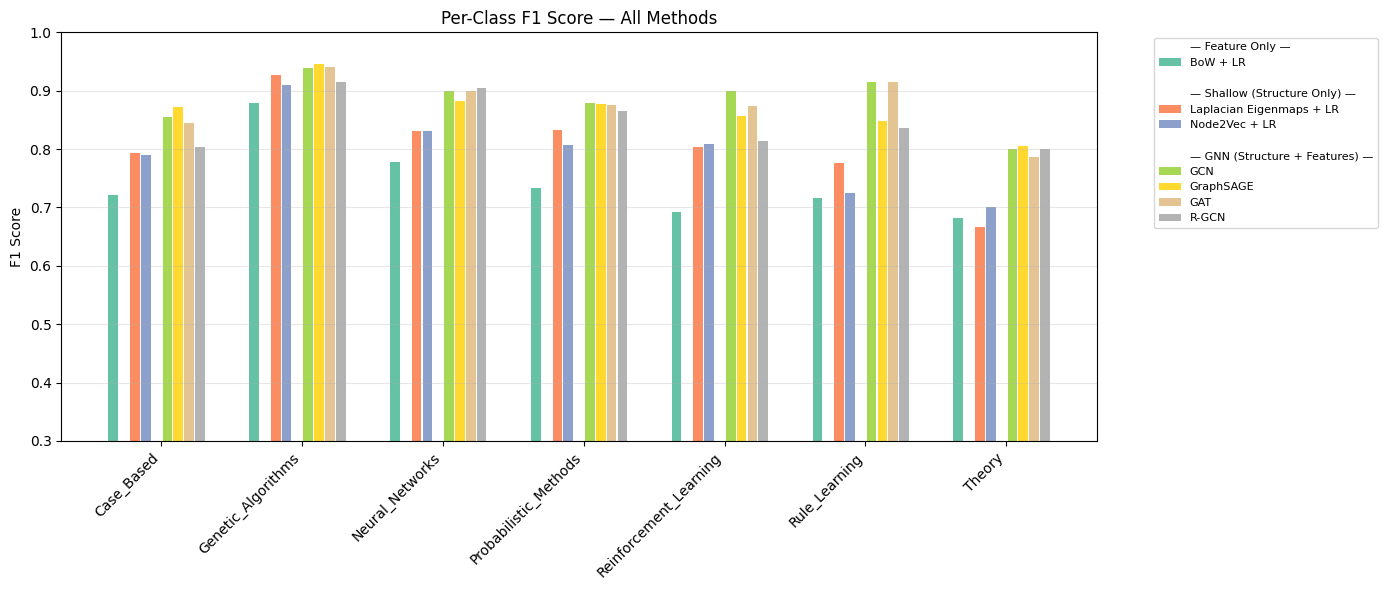

In [81]:
# ==============================================================================
# 11.4  Per-class F1 Analysis (with gaps between method groups)
# ==============================================================================
f1_df = pd.DataFrame(
    {name: r['f1_per_class'] for name, r in results_a.items()},
    index=class_names
)

method_names = list(results_a.keys())
# Groups: [BoW+LR] gap [Laplacian, Node2Vec] gap [GCN, GraphSAGE, GAT, R-GCN]
# Offsets within each class cluster, with small gaps between groups
bar_offsets = [0,   0.20, 0.30,   0.50, 0.60, 0.70, 0.80]
bar_width = 0.09
colors = plt.cm.Set2(np.linspace(0, 1, len(method_names)))

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(class_names)) * 1.3

for mi, method in enumerate(method_names):
    vals = f1_df[method].values
    ax.bar(x + bar_offsets[mi], vals, width=bar_width, label=method, color=colors[mi])

ax.set_ylabel('F1 Score')
ax.set_title('Per-Class F1 Score — All Methods')
center = np.mean(bar_offsets)
ax.set_xticks(x + center)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.set_ylim(0.3, 1)
ax.grid(axis='y', alpha=0.3)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Build grouped legend
legend_elements = [
    Patch(facecolor='white', edgecolor='white', label='— Feature Only —'),
    Patch(facecolor=colors[0], label=method_names[0]),
    Patch(facecolor='white', edgecolor='white', label=''),
    Patch(facecolor='white', edgecolor='white', label='— Shallow (Structure Only) —'),
    Patch(facecolor=colors[1], label=method_names[1]),
    Patch(facecolor=colors[2], label=method_names[2]),
    Patch(facecolor='white', edgecolor='white', label=''),
    Patch(facecolor='white', edgecolor='white', label='— GNN (Structure + Features) —'),
    Patch(facecolor=colors[3], label=method_names[3]),
    Patch(facecolor=colors[4], label=method_names[4]),
    Patch(facecolor=colors[5], label=method_names[5]),
    Patch(facecolor=colors[6], label=method_names[6]),
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1),
          loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()


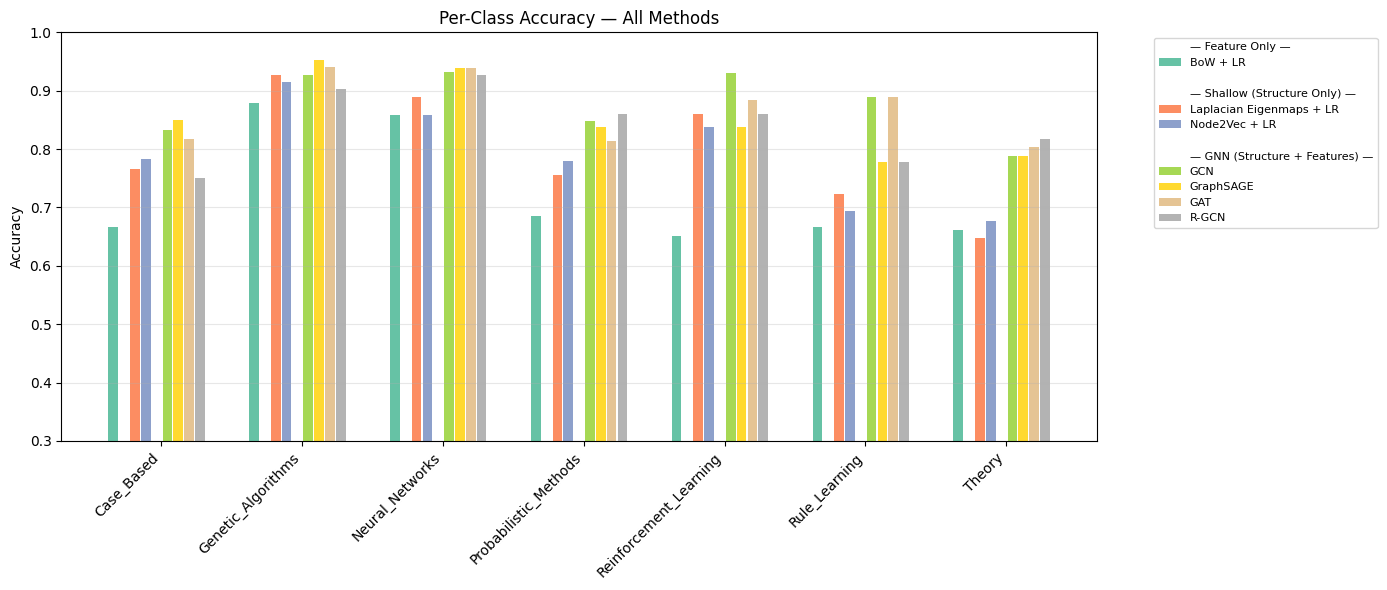


Average Accuracy across all methods per class:
  Theory                          avg Acc = 0.740
  Rule_Learning                   avg Acc = 0.774
  Case_Based                      avg Acc = 0.781
  Probabilistic_Methods           avg Acc = 0.797
  Reinforcement_Learning          avg Acc = 0.837
  Neural_Networks                 avg Acc = 0.906
  Genetic_Algorithms              avg Acc = 0.921

Hardest class: Theory (avg Acc = 0.740)


In [82]:
# ==============================================================================
# 11.5  Per-class Accuracy Analysis (with gaps between method groups)
# ==============================================================================
acc_per_class = {}
for name, r in results_a.items():
    cm = confusion_matrix(r['y_true'], r['y_pred'])
    acc_per_class[name] = cm.diagonal() / cm.sum(axis=1)

acc_df = pd.DataFrame(acc_per_class, index=class_names)

method_names = list(results_a.keys())
bar_offsets = [0,   0.20, 0.30,   0.50, 0.60, 0.70, 0.80]
bar_width = 0.09
colors = plt.cm.Set2(np.linspace(0, 1, len(method_names)))

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(class_names)) * 1.3

for mi, method in enumerate(method_names):
    vals = acc_df[method].values
    ax.bar(x + bar_offsets[mi], vals, width=bar_width, label=method, color=colors[mi])

ax.set_ylabel('Accuracy')
ax.set_title('Per-Class Accuracy — All Methods')
center = np.mean(bar_offsets)
ax.set_xticks(x + center)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.set_ylim(0.3, 1)
ax.grid(axis='y', alpha=0.3)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Build grouped legend
legend_elements = [
    Patch(facecolor='white', edgecolor='white', label='— Feature Only —'),
    Patch(facecolor=colors[0], label=method_names[0]),
    Patch(facecolor='white', edgecolor='white', label=''),
    Patch(facecolor='white', edgecolor='white', label='— Shallow (Structure Only) —'),
    Patch(facecolor=colors[1], label=method_names[1]),
    Patch(facecolor=colors[2], label=method_names[2]),
    Patch(facecolor='white', edgecolor='white', label=''),
    Patch(facecolor='white', edgecolor='white', label='— GNN (Structure + Features) —'),
    Patch(facecolor=colors[3], label=method_names[3]),
    Patch(facecolor=colors[4], label=method_names[4]),
    Patch(facecolor=colors[5], label=method_names[5]),
    Patch(facecolor=colors[6], label=method_names[6]),
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1),
          loc='upper left', fontsize=8)


plt.tight_layout()
plt.show()

# Identify hardest classes
mean_acc_per_class = acc_df.mean(axis=1)
print(f"\nAverage Accuracy across all methods per class:")
for cn, acc in mean_acc_per_class.sort_values().items():
    print(f"  {cn:30s}  avg Acc = {acc:.3f}")
print(f"\nHardest class: {mean_acc_per_class.idxmin()} (avg Acc = {mean_acc_per_class.min():.3f})")


/tmp/ipython-input-1378574601.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(methods, rotation=45, ha='right')
/tmp/ipython-input-1378574601.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(methods, rotation=45, ha='right')


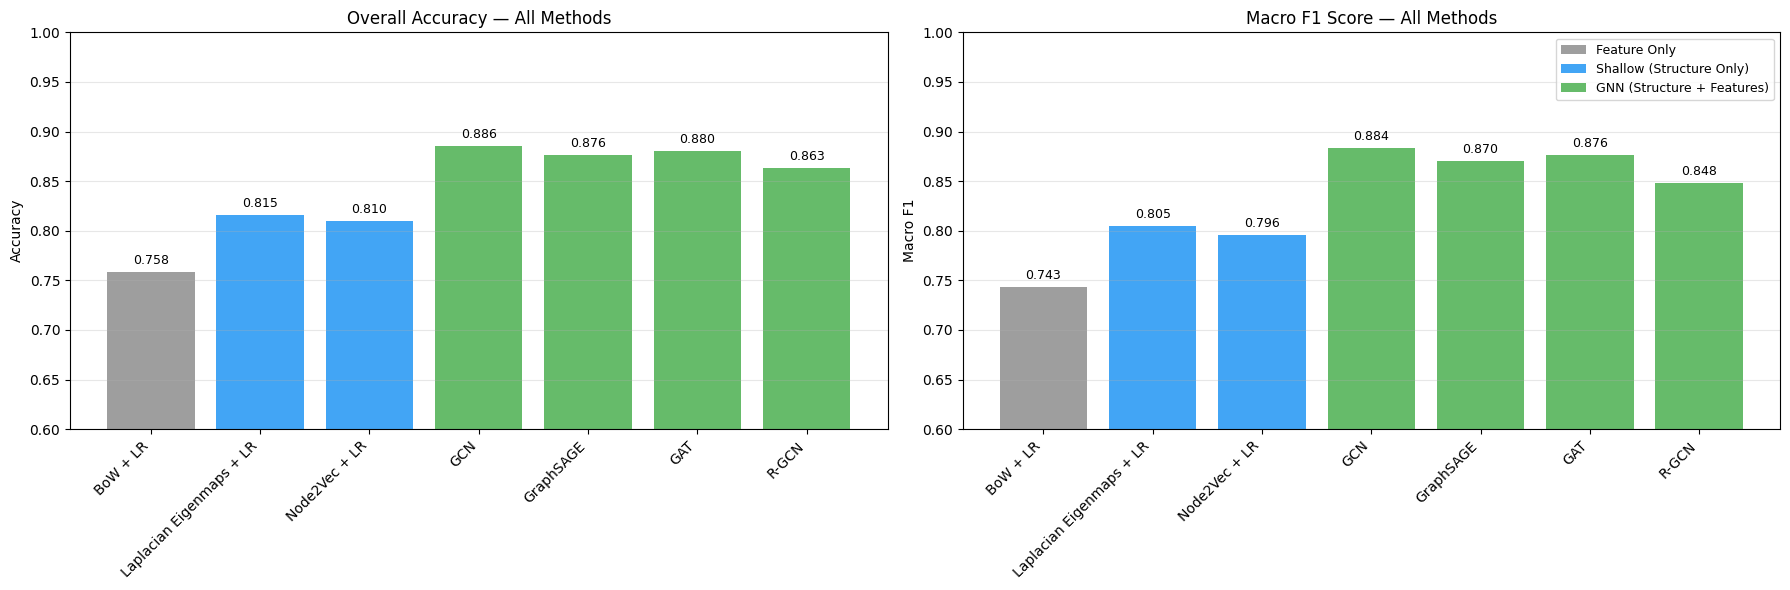

In [83]:
# ==============================================================================
# Overall Accuracy & Macro F1 — Separate Bar Charts (colored by group)
# ==============================================================================
methods = list(results_a.keys())
accs = [results_a[m]['accuracy'] for m in methods]
f1s = [results_a[m]['f1_macro'] for m in methods]

# Colors by group: feature-only | shallow | GNN-based
bar_colors = ['#9E9E9E',                          # BoW+LR (gray)
              '#42A5F5', '#42A5F5',                # Laplacian, Node2Vec (blue)
              '#66BB6A', '#66BB6A', '#66BB6A', '#66BB6A']  # GCN, SAGE, GAT, R-GCN (green)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Accuracy
bars1 = ax1.bar(methods, accs, color=bar_colors)
ax1.set_ylabel('Accuracy')
ax1.set_title('Overall Accuracy — All Methods')
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.set_ylim(0.6, 1)
ax1.grid(axis='y', alpha=0.3)
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

# Macro F1
bars2 = ax2.bar(methods, f1s, color=bar_colors)
ax2.set_ylabel('Macro F1')
ax2.set_title('Macro F1 Score — All Methods')
ax2.set_xticklabels(methods, rotation=45, ha='right')
ax2.set_ylim(0.6, 1)
ax2.grid(axis='y', alpha=0.3)
for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

# Shared legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#9E9E9E', label='Feature Only'),
    Patch(facecolor='#42A5F5', label='Shallow (Structure Only)'),
    Patch(facecolor='#66BB6A', label='GNN (Structure + Features)'),
]
ax2.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()


---
### Misclassification Analysis — Neighborhood Homophily

Accuracy and F1 scores tell us *how well* a GNN performs overall, but not *which nodes* it fails on and *why*. This analysis investigates the root cause of GCN misclassifications by computing each test node's **local neighborhood homophily** — the fraction of its direct neighbors that share its true class label.

The hypothesis is that GNN message passing is inherently vulnerable to low homophily: when a node's neighbors mostly belong to different classes, the aggregated neighborhood signal actively misleads the classifier rather than helping it. By grouping test nodes into homophily bins and measuring classification accuracy within each bin (using GCN as a representative model), we can directly quantify this effect.


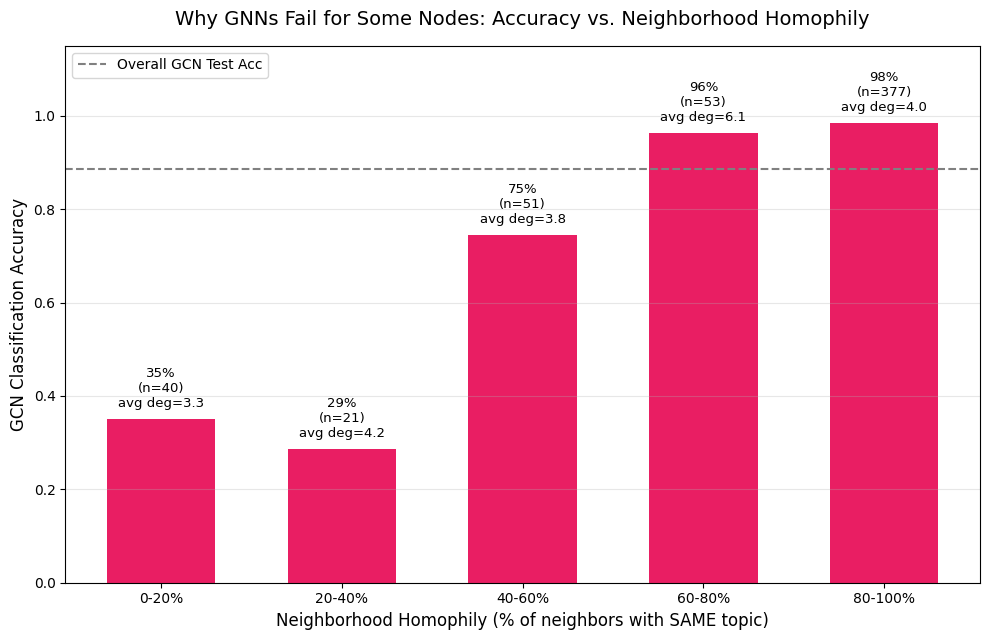

In [92]:
# ==============================================================================
# Misclassification Analysis: Accuracy vs. Neighborhood Homophily (using GCN)
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np

# 1. Compute Local Homophily for each node
edge_index_np = data.edge_index.cpu().numpy()
labels_np = data.y.cpu().numpy()
num_nodes = data.num_nodes

# Count matching neighbors
matches = np.zeros(num_nodes)
total_neighbors = np.zeros(num_nodes)

for src, dst in zip(edge_index_np[0], edge_index_np[1]):
    total_neighbors[src] += 1
    if labels_np[src] == labels_np[dst]:
        matches[src] += 1

# Avoid division by zero for isolated nodes
with np.errstate(divide='ignore', invalid='ignore'):
    local_homophily = np.where(total_neighbors > 0, matches / total_neighbors, 0)

# 2. Get test set results (using GCN as the representative model)
test_indices = np.where(data.test_mask.cpu().numpy())[0]
y_pred_gcn = results_a['GCN']['y_pred']
y_true_gcn = results_a['GCN']['y_true']
correct = (y_pred_gcn == y_true_gcn)

test_homophily = local_homophily[test_indices]
test_degrees = total_neighbors[test_indices]

# 3. Group by Homophily Bins
homophily_bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.01]
homophily_labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
homophily_groups = np.digitize(test_homophily, homophily_bins) - 1

acc_by_homophily = []
avg_deg_by_homophily = []

for i in range(len(homophily_labels)):
    mask = (homophily_groups == i)
    mask = mask & (test_degrees > 0) # Only consider connected nodes
    
    if mask.sum() > 0:
        acc_by_homophily.append(correct[mask].mean())
        avg_deg_by_homophily.append(test_degrees[mask].mean())
    else:
        acc_by_homophily.append(0)
        avg_deg_by_homophily.append(0)

# 4. Plot
fig, ax = plt.subplots(figsize=(10, 6.5))
bars = ax.bar(homophily_labels, acc_by_homophily, color='#E91E63', width=0.6)

# Add sample counts and avg degree as text inside the bars
for i, bar in enumerate(bars):
    mask = (homophily_groups == i) & (test_degrees > 0)
    count = mask.sum()
    yval = bar.get_height()
    avg_deg = avg_deg_by_homophily[i]
    
    if count > 0:
        label = f'{yval:.0%}\n(n={count})\navg deg={avg_deg:.1f}'
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02,
                label, ha='center', va='bottom', fontsize=9.5)

ax.axhline(y=results_a['GCN']['accuracy'], color='gray', linestyle='--', label='Overall GCN Test Acc')
ax.set_title('Why GNNs Fail for Some Nodes: Accuracy vs. Neighborhood Homophily', fontsize=14, pad=15)
ax.set_xlabel('Neighborhood Homophily (% of neighbors with SAME topic)', fontsize=12)
ax.set_ylabel('GCN Classification Accuracy', fontsize=12)
ax.set_ylim(0, 1.15) # Extra room for top labels
ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### Key Insight: Why GNNs Misclassify Papers

This analysis reveals a critical vulnerability in how Graph Neural Networks operate: **Accuracy is strictly bound to neighborhood purity.**

- **The Homophily Advantage:** When a paper sits in a well-defined community (60% to 100% of its neighbors share the same topic), the GCN performs flawlessly, achieving **75% to 98% accuracy**. Message passing works exactly as intended here — aggregating features from similar neighbors reinforces the correct class signal.
- **The Bridge-Paper Penalty:** If a paper acts as a bridge between different research domains (less than 40% of its neighbors share its topic), accuracy plummets to a dismal **29% to 35%**. 

**Why does this happen?** Because standard GCNs treat all edges equally. When a paper cites heavily outside its domain, the GCN forcibly aggregates those "foreign" neighbor features. Instead of providing useful context, the message passing essentially floods the node with noise from other classes, causing the model to confidently misclassify the paper into the topics of its neighbors.


### Discussion — Node Classification Trade-offs

**Value of the graph**: BoW+LR (no graph) vs GCN (graph+features) — 75.8% → 88.6% (+12.8pp), directly quantifying how much citation links add beyond paper content alone.

**Value of features**: Node2Vec (structure only) vs GCN (structure+features) — 81.0% → 88.6% (+7.6pp), showing how much the 1433-d BoW adds on top of graph structure.

**Value of directionality**: GCN (undirected) vs R-GCN (directed) — 88.6% → 86.4% (−2.2pp). Directionality does not help on Cora: the graph's high homophily means citing and being cited are equally informative about topic.

**Expressiveness**: Shallow embeddings (Node2Vec, Laplacian Eigenmaps) are fast but cannot combine features+structure. GNNs do end-to-end feature propagation.

**Transductive vs Inductive**: Node2Vec, GCN, GAT, R-GCN cannot classify a new paper added after training (transductive). GraphSAGE can (inductive) — crucial for production systems where new papers arrive daily.

**Data Imbalance**: Cora is moderately imbalanced (Neural_Networks has 818 papers vs. Rule_Learning's 180). We use Macro F1 alongside accuracy to ensure smaller classes are not overshadowed in the evaluation.


---
# Part B — Link Prediction

Having evaluated graph embeddings for **node classification**, we now turn to the second downstream task: **link prediction**. The goal is to predict whether a citation edge should exist between two papers — i.e., given paper A and paper B, should A cite B?

Beyond evaluation, this has direct practical value: a well-performing link prediction model on Cora could power **paper discovery systems** — recommending relevant prior work that an author may have missed, or surfacing papers that are likely to be cited by a new submission based on its content and the existing citation graph.

This is a fundamentally different challenge from node classification: instead of assigning labels to individual nodes, the model must score **pairs of nodes** based on whether their embeddings are compatible for a link. We evaluate three families of approaches, progressively increasing in expressiveness:
1. **Node2Vec + scorer** (dot product, cosine, MLP) — structure-only, using embeddings trained for node proximity
2. **TransE** — a translational knowledge graph embedding model, explicitly exploiting citation directionality
3. **GCN / GAT + MLP decoder** — combining structural and textual features with an end-to-end learned link scoring function

**Evaluation metrics:** We use **AUC-ROC** and **Average Precision (AP)**. Standard accuracy is inappropriate for link prediction — on a sparse graph, a trivial "always predict no-edge" classifier would get >99% accuracy. AUC-ROC is threshold-independent and measures how well the model ranks true edges above false ones; AP is stricter, penalizing false positives more heavily and making it a more practically meaningful metric when the positive class (real citations) is rare.

In [62]:
# ==============================================================================
# 12.1  Link Prediction — Edge splitting with RandomLinkSplit
# ==============================================================================
# We need a fresh Data object for link prediction (using the directed edges)
# RandomLinkSplit handles: splitting edges, adding negative samples, and
# ensuring the training graph remains connected.

data_lp = Data(x=data.x.clone(), edge_index=data.edge_index_directed.clone(), y=data.y.clone())
data_lp.num_classes = len(class_names)

transform = RandomLinkSplit(
    num_val=0.05,
    num_test=0.10,
    is_undirected=False,       # directed graph
    add_negative_train_samples=True,
    neg_sampling_ratio=1.0,    # 1:1 ratio
    split_labels=True,
)

train_data_lp, val_data_lp, test_data_lp = transform(data_lp)

print(f"Link Prediction Split:")
print(f"  Train edges: {train_data_lp.pos_edge_label_index.shape[1]} pos + "
      f"{train_data_lp.neg_edge_label_index.shape[1]} neg")
print(f"  Val edges:   {val_data_lp.pos_edge_label_index.shape[1]} pos + "
      f"{val_data_lp.neg_edge_label_index.shape[1]} neg")
print(f"  Test edges:  {test_data_lp.pos_edge_label_index.shape[1]} pos + "
      f"{test_data_lp.neg_edge_label_index.shape[1]} neg")
print(f"  Training graph edges: {train_data_lp.edge_index.shape[1]}")

Link Prediction Split:
  Train edges: 4616 pos + 4616 neg
  Val edges:   271 pos + 271 neg
  Test edges:  542 pos + 542 neg
  Training graph edges: 4616


In [63]:
# ==============================================================================
# 12.2  Link Prediction — Evaluation helpers
# ==============================================================================
results_b = {}  # {method_name: {'auc': ..., 'ap': ...}}

def evaluate_link_prediction(pos_scores, neg_scores, method_name):
    """Evaluate link prediction using AUC-ROC and Average Precision."""
    y_true = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    y_scores = np.concatenate([pos_scores, neg_scores])
    auc = roc_auc_score(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    results_b[method_name] = {'auc': auc, 'ap': ap}
    print(f"  {method_name:35s}  AUC-ROC={auc:.4f}  AP={ap:.4f}")
    return auc, ap

---
## Method 1 — Node2Vec + Scoring (Structure Only)

The simplest link prediction baseline: reuse Node2Vec's ability to capture **structural proximity** through random-walk co-occurrence. If two papers are frequently co-visited in random walks, their embeddings will be close — and papers that tend to be cited together are likely citation-compatible. No features are used; the hypothesis is that topology alone contains enough signal to predict links.

Node2Vec is trained on the **training subgraph** (held-out test edges removed to avoid data leakage). Candidate pairs are then scored using three functions:
- **Dot Product** — measures raw alignment between embedding vectors
- **Cosine Similarity** — measures angular similarity (direction, not magnitude)
- **Hadamard + MLP** — element-wise product fed to a learned scorer, allowing more expressive, asymmetric link scoring



In [64]:
# ==============================================================================
# 13.1  Train Node2Vec on the link prediction training subgraph
# ==============================================================================
# Make the training graph undirected for Node2Vec
train_edge_undir = to_undirected(train_data_lp.edge_index)

n2v_lp = Node2Vec(
    edge_index=train_edge_undir,
    embedding_dim=128,
    walk_length=80,
    context_size=10,
    walks_per_node=10,
    p=1.0, q=1.0,
    num_nodes=data.num_nodes,
    sparse=True,
).to(device)

loader_lp = n2v_lp.loader(batch_size=256, shuffle=True, num_workers=0)
optimizer_lp = torch.optim.SparseAdam(n2v_lp.parameters(), lr=0.01)

n2v_lp.train()
for epoch in range(1, 501):
    total_loss = 0
    n_batch = 0
    for pos_rw, neg_rw in loader_lp:
        optimizer_lp.zero_grad()
        loss = n2v_lp.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer_lp.step()
        total_loss += loss.item()
        n_batch += 1
    if epoch % 25 == 0:
        print(f"  N2V-LP Epoch {epoch}  Loss: {total_loss/n_batch:.4f}")

n2v_lp.eval()
with torch.no_grad():
    lp_embeddings = n2v_lp().detach().cpu().numpy()
print(f"\nNode2Vec LP embeddings shape: {lp_embeddings.shape}")

  N2V-LP Epoch 25  Loss: 0.9452
  N2V-LP Epoch 50  Loss: 0.8277
  N2V-LP Epoch 75  Loss: 0.8105
  N2V-LP Epoch 100  Loss: 0.8055
  N2V-LP Epoch 125  Loss: 0.8032
  N2V-LP Epoch 150  Loss: 0.8023
  N2V-LP Epoch 175  Loss: 0.8016
  N2V-LP Epoch 200  Loss: 0.8013
  N2V-LP Epoch 225  Loss: 0.8014
  N2V-LP Epoch 250  Loss: 0.8004
  N2V-LP Epoch 275  Loss: 0.8005
  N2V-LP Epoch 300  Loss: 0.8004
  N2V-LP Epoch 325  Loss: 0.8005
  N2V-LP Epoch 350  Loss: 0.8006
  N2V-LP Epoch 375  Loss: 0.8003
  N2V-LP Epoch 400  Loss: 0.8003
  N2V-LP Epoch 425  Loss: 0.8001
  N2V-LP Epoch 450  Loss: 0.8008
  N2V-LP Epoch 475  Loss: 0.8002
  N2V-LP Epoch 500  Loss: 0.7999

Node2Vec LP embeddings shape: (2708, 128)


In [65]:
# ============================ ==================================================
# 13.2  Scoring functions: dot product, cosine, Hadamard + MLP
# ==============================================================================
def score_pairs(emb, edge_index, method='dot'):
    """Score node pairs using the given method."""
    src = emb[edge_index[0].cpu().numpy()]
    dst = emb[edge_index[1].cpu().numpy()]

    if method == 'dot':
        return (src * dst).sum(axis=1)
    elif method == 'cosine':
        norm_src = src / (np.linalg.norm(src, axis=1, keepdims=True) + 1e-8)
        norm_dst = dst / (np.linalg.norm(dst, axis=1, keepdims=True) + 1e-8)
        return (norm_src * norm_dst).sum(axis=1)
    else:
        raise ValueError(f"Unknown method: {method}")

# Dot product scoring
print("Node2Vec Link Prediction Results:")
pos_scores_dot = score_pairs(lp_embeddings, test_data_lp.pos_edge_label_index, 'dot')
neg_scores_dot = score_pairs(lp_embeddings, test_data_lp.neg_edge_label_index, 'dot')
evaluate_link_prediction(pos_scores_dot, neg_scores_dot, 'Node2Vec + Dot Product')

# Cosine scoring
pos_scores_cos = score_pairs(lp_embeddings, test_data_lp.pos_edge_label_index, 'cosine')
neg_scores_cos = score_pairs(lp_embeddings, test_data_lp.neg_edge_label_index, 'cosine')
evaluate_link_prediction(pos_scores_cos, neg_scores_cos, 'Node2Vec + Cosine')

Node2Vec Link Prediction Results:
  Node2Vec + Dot Product               AUC-ROC=0.8771  AP=0.9133
  Node2Vec + Cosine                    AUC-ROC=0.8759  AP=0.9060


(np.float64(0.8759480399232036), np.float64(0.906039894768427))

In [66]:
# ==============================================================================
# 13.3  Hadamard product + MLP scorer (asymmetric — good for directed graphs)
# ==============================================================================
class MLPScorer(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
        )
    def forward(self, z_src, z_dst):
        h = z_src * z_dst  # Hadamard product
        return self.net(h).squeeze(-1)

# Train MLP scorer
emb_tensor = torch.tensor(lp_embeddings, dtype=torch.float).to(device)
mlp_scorer = MLPScorer(128).to(device)
opt_mlp = torch.optim.Adam(mlp_scorer.parameters(), lr=0.001)

# Prepare training data
train_pos = train_data_lp.pos_edge_label_index.to(device)
train_neg = train_data_lp.neg_edge_label_index.to(device)

mlp_scorer.train()
for epoch in range(1, 1001):
    opt_mlp.zero_grad()
    pos_out = mlp_scorer(emb_tensor[train_pos[0]], emb_tensor[train_pos[1]])
    neg_out = mlp_scorer(emb_tensor[train_neg[0]], emb_tensor[train_neg[1]])
    labels_lp = torch.cat([torch.ones_like(pos_out), torch.zeros_like(neg_out)])
    preds_lp = torch.cat([pos_out, neg_out])
    loss = F.binary_cross_entropy_with_logits(preds_lp, labels_lp)
    loss.backward()
    opt_mlp.step()
    if epoch % 50 == 0:
        print(f"  MLP Scorer Epoch {epoch}  Loss: {loss.item():.4f}")

# Evaluate MLP scorer
mlp_scorer.eval()
with torch.no_grad():
    test_pos_idx = test_data_lp.pos_edge_label_index.to(device)
    test_neg_idx = test_data_lp.neg_edge_label_index.to(device)
    pos_scores_mlp = torch.sigmoid(
        mlp_scorer(emb_tensor[test_pos_idx[0]], emb_tensor[test_pos_idx[1]])).cpu().numpy()
    neg_scores_mlp = torch.sigmoid(
        mlp_scorer(emb_tensor[test_neg_idx[0]], emb_tensor[test_neg_idx[1]])).cpu().numpy()

evaluate_link_prediction(pos_scores_mlp, neg_scores_mlp, 'Node2Vec + MLP (Hadamard)')

  MLP Scorer Epoch 50  Loss: 0.4504
  MLP Scorer Epoch 100  Loss: 0.2461
  MLP Scorer Epoch 150  Loss: 0.1361
  MLP Scorer Epoch 200  Loss: 0.0786
  MLP Scorer Epoch 250  Loss: 0.0526
  MLP Scorer Epoch 300  Loss: 0.0396
  MLP Scorer Epoch 350  Loss: 0.0325
  MLP Scorer Epoch 400  Loss: 0.0271
  MLP Scorer Epoch 450  Loss: 0.0241
  MLP Scorer Epoch 500  Loss: 0.0217
  MLP Scorer Epoch 550  Loss: 0.0193
  MLP Scorer Epoch 600  Loss: 0.0183
  MLP Scorer Epoch 650  Loss: 0.0171
  MLP Scorer Epoch 700  Loss: 0.0165
  MLP Scorer Epoch 750  Loss: 0.0159
  MLP Scorer Epoch 800  Loss: 0.0144
  MLP Scorer Epoch 850  Loss: 0.0147
  MLP Scorer Epoch 900  Loss: 0.0143
  MLP Scorer Epoch 950  Loss: 0.0138
  MLP Scorer Epoch 1000  Loss: 0.0127
  Node2Vec + MLP (Hadamard)            AUC-ROC=0.8440  AP=0.8942


(np.float64(0.8439614792826895), np.float64(0.8941552157457764))

### Node2Vec Link Prediction — Results Analysis

All three scorers perform competitively, confirming that **topological proximity alone is a strong predictor of citations**. The simple **Dot Product** scorer achieves the best AUC-ROC (0.877) and **Cosine** follows closely (0.876), showing that the angular alignment of Node2Vec embeddings naturally captures citation likelihood. 

Surprisingly, the **MLP scorer** (0.844 AUC-ROC) underperforms the simpler baselines, despite being more expressive. This is likely because the MLP is trained only on the training edges with a relatively small dataset — the simpler scorers benefit from not overfitting, while the MLP may be learning spurious patterns in the limited training set.


---
## Method 2 — TransE (Translational Knowledge Graph Embedding, Structure Only)

Node2Vec treats citations as undirected proximity — it has no sense of **direction**. TransE addresses this by modeling each citation as a directional relationship: citing a paper is fundamentally different from being cited by it. By learning a shared "cites" relation vector, TransE explicitly captures these asymmetric patterns in the citation graph — making it a natural structure-only directed counterpart to Node2Vec, with no node features involved.


In [67]:
# ==============================================================================
# 14.1  TransE Model
# ==============================================================================
class TransE(nn.Module):
    def __init__(self, num_entities, embedding_dim, margin=1.0):
        super().__init__()
        self.entity_emb = nn.Embedding(num_entities, embedding_dim)
        self.relation_emb = nn.Parameter(torch.randn(embedding_dim))
        self.margin = margin
        # Xavier initialization
        nn.init.xavier_uniform_(self.entity_emb.weight)

    def score(self, head_idx, tail_idx):
        """Score = -||h + r - t||  (higher = more likely)."""
        h = self.entity_emb(head_idx)
        t = self.entity_emb(tail_idx)
        return -torch.norm(h + self.relation_emb - t, p=2, dim=-1)

    def loss(self, pos_head, pos_tail, neg_head, neg_tail):
        """Margin-based ranking loss."""
        pos_score = -torch.norm(
            self.entity_emb(pos_head) + self.relation_emb - self.entity_emb(pos_tail),
            p=2, dim=-1)
        neg_score = -torch.norm(
            self.entity_emb(neg_head) + self.relation_emb - self.entity_emb(neg_tail),
            p=2, dim=-1)
        return F.relu(self.margin - pos_score + neg_score).mean()

In [68]:
# ==============================================================================
# 14.2  Train TransE
# ==============================================================================
transe = TransE(num_entities=data.num_nodes, embedding_dim=128, margin=1.0).to(device)
opt_transe = torch.optim.Adam(transe.parameters(), lr=0.001)

# Use the same train/test split as other LP methods
train_pos_lp = train_data_lp.pos_edge_label_index.to(device)
train_neg_lp = train_data_lp.neg_edge_label_index.to(device)

NUM_EPOCHS_TE = 1000
BATCH_SIZE_TE = 512

transe.train()
for epoch in range(1, NUM_EPOCHS_TE + 1):
    # Shuffle training edges
    perm = torch.randperm(train_pos_lp.shape[1])
    total_loss = 0
    n_batch = 0

    for i in range(0, len(perm), BATCH_SIZE_TE):
        batch_idx = perm[i:i + BATCH_SIZE_TE]
        pos_h = train_pos_lp[0, batch_idx]
        pos_t = train_pos_lp[1, batch_idx]

        # Generate fresh negative samples for each batch
        neg_idx = torch.randint(0, data.num_nodes, (len(batch_idx),), device=device)
        # Corrupt tail with 50% probability, head otherwise
        corrupt_tail = torch.rand(len(batch_idx), device=device) > 0.5
        neg_h = torch.where(corrupt_tail, pos_h, neg_idx)
        neg_t = torch.where(corrupt_tail, neg_idx, pos_t)

        opt_transe.zero_grad()
        loss = transe.loss(pos_h, pos_t, neg_h, neg_t)
        loss.backward()
        opt_transe.step()
        total_loss += loss.item()
        n_batch += 1

    if epoch % 50 == 0 or epoch == 1:
        print(f"  TransE Epoch {epoch:3d}  Loss: {total_loss/n_batch:.4f}")

print("TransE training complete.")

  TransE Epoch   1  Loss: 0.9913
  TransE Epoch  50  Loss: 0.5730
  TransE Epoch 100  Loss: 0.5749
  TransE Epoch 150  Loss: 0.5180
  TransE Epoch 200  Loss: 0.1762
  TransE Epoch 250  Loss: 0.0702
  TransE Epoch 300  Loss: 0.0405
  TransE Epoch 350  Loss: 0.0271
  TransE Epoch 400  Loss: 0.0253
  TransE Epoch 450  Loss: 0.0154
  TransE Epoch 500  Loss: 0.0140
  TransE Epoch 550  Loss: 0.0119
  TransE Epoch 600  Loss: 0.0093
  TransE Epoch 650  Loss: 0.0091
  TransE Epoch 700  Loss: 0.0052
  TransE Epoch 750  Loss: 0.0075
  TransE Epoch 800  Loss: 0.0054
  TransE Epoch 850  Loss: 0.0058
  TransE Epoch 900  Loss: 0.0224
  TransE Epoch 950  Loss: 0.0063
  TransE Epoch 1000  Loss: 0.0064
TransE training complete.


In [69]:
# ==============================================================================
# 14.3  Evaluate TransE on test edges
# ==============================================================================
transe.eval()
with torch.no_grad():
    test_pos_h = test_data_lp.pos_edge_label_index[0].to(device)
    test_pos_t = test_data_lp.pos_edge_label_index[1].to(device)
    test_neg_h = test_data_lp.neg_edge_label_index[0].to(device)
    test_neg_t = test_data_lp.neg_edge_label_index[1].to(device)

    pos_scores_te = transe.score(test_pos_h, test_pos_t).cpu().numpy()
    neg_scores_te = transe.score(test_neg_h, test_neg_t).cpu().numpy()

evaluate_link_prediction(pos_scores_te, neg_scores_te, 'TransE')

  TransE                               AUC-ROC=0.8758  AP=0.9028


(np.float64(0.8758254925722689), np.float64(0.9027731143030091))

### TransE — Results Analysis

TransE achieves **AUC-ROC = 0.876 and AP = 0.903** — virtually on par with Node2Vec + Dot Product (0.877 / 0.913) despite using a fundamentally different, direction-aware model. This is a notable result: on Cora, explicitly modeling directionality provides **no advantage** over simple proximity-based scoring. The likely explanation is Cora's high homophily — since citations predominantly connect same-topic papers regardless of direction, the asymmetric "cites" signal adds little predictive value. TransE shines in multi-relational knowledge graphs with diverse, asymmetric relations; with a single homophilic relation like `cites`, its directional inductive bias is unnecessary.


---
## Method 3 — GCN + MLP Decoder (Structure + Features)

Node2Vec and TransE learn embeddings purely from graph topology — they never see the 1433-d BoW features. GCN with a link prediction head bridges this gap: a **GCN encoder** propagates and mixes paper content features through the citation graph to produce rich, topology-aware embeddings, which are then passed to an **MLP decoder** that scores whether a pair of nodes should be linked.

Critically, this model is trained end-to-end **directly for link prediction**, not reusing embeddings from node classification. The decoder takes both node embeddings in order, making it directionally sensitive — scoring "A cites B" differently from "B cites A". This lets the model learn which feature combinations make one paper likely to cite another, combining GCN's structural expressiveness with a learned, task-specific scoring function.


In [70]:
# ==============================================================================
# 15.1  GCN Link Prediction Encoder + MLP Decoder
# ==============================================================================
class GCNLinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout
        # MLP decoder: concatenation [z_u || z_v] → score (asymmetric)
        self.decoder = nn.Sequential(
            nn.Linear(out_channels * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
        )

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        src, dst = edge_index
        z_cat = torch.cat([z[src], z[dst]], dim=-1)
        return self.decoder(z_cat).squeeze(-1)

In [71]:
# ==============================================================================
# 15.2  Train GCN Link Predictor
# ==============================================================================
# Make training graph undirected for GCN message passing
train_ei_undir_lp = to_undirected(train_data_lp.edge_index)

gcn_lp = GCNLinkPredictor(
    in_channels=data.num_node_features,
    hidden_channels=128,
    out_channels=64,
    dropout=0.5
).to(device)

opt_gcn_lp = torch.optim.Adam(gcn_lp.parameters(), lr=0.01, weight_decay=5e-4)
x_dev = data.x.to(device)
train_ei_dev = train_ei_undir_lp.to(device)

best_val_auc_gcn = 0
best_gcn_lp_state = None

for epoch in range(1, 501):
    gcn_lp.train()
    opt_gcn_lp.zero_grad()

    z = gcn_lp.encode(x_dev, train_ei_dev)

    # Positive and negative edges
    pos_ei = train_data_lp.pos_edge_label_index.to(device)
    neg_ei = train_data_lp.neg_edge_label_index.to(device)

    pos_out = gcn_lp.decode(z, pos_ei)
    neg_out = gcn_lp.decode(z, neg_ei)

    out = torch.cat([pos_out, neg_out])
    lbl = torch.cat([torch.ones_like(pos_out), torch.zeros_like(neg_out)])
    loss = F.binary_cross_entropy_with_logits(out, lbl)
    loss.backward()
    opt_gcn_lp.step()

    # Validation
    if epoch % 10 == 0:
        gcn_lp.eval()
        with torch.no_grad():
            z = gcn_lp.encode(x_dev, train_ei_dev)
            val_pos = val_data_lp.pos_edge_label_index.to(device)
            val_neg = val_data_lp.neg_edge_label_index.to(device)
            vp = torch.sigmoid(gcn_lp.decode(z, val_pos)).cpu().numpy()
            vn = torch.sigmoid(gcn_lp.decode(z, val_neg)).cpu().numpy()
            val_auc = roc_auc_score(
                np.concatenate([np.ones(len(vp)), np.zeros(len(vn))]),
                np.concatenate([vp, vn]))
            if val_auc > best_val_auc_gcn:
                best_val_auc_gcn = val_auc
                best_gcn_lp_state = {k: v.cpu().clone()
                                     for k, v in gcn_lp.state_dict().items()}
        if epoch % 50 == 0:
            print(f"  GCN-LP Epoch {epoch}  Loss={loss.item():.4f}  Val AUC={val_auc:.4f}")

# Restore best and evaluate
gcn_lp.load_state_dict(best_gcn_lp_state)
gcn_lp = gcn_lp.to(device)
gcn_lp.eval()
with torch.no_grad():
    z = gcn_lp.encode(x_dev, train_ei_dev)
    tp = test_data_lp.pos_edge_label_index.to(device)
    tn = test_data_lp.neg_edge_label_index.to(device)
    pos_s = torch.sigmoid(gcn_lp.decode(z, tp)).cpu().numpy()
    neg_s = torch.sigmoid(gcn_lp.decode(z, tn)).cpu().numpy()

evaluate_link_prediction(pos_s, neg_s, 'GCN + MLP Decoder')

  GCN-LP Epoch 50  Loss=0.4263  Val AUC=0.6877
  GCN-LP Epoch 100  Loss=0.1763  Val AUC=0.7936
  GCN-LP Epoch 150  Loss=0.0932  Val AUC=0.8141
  GCN-LP Epoch 200  Loss=0.0717  Val AUC=0.8116
  GCN-LP Epoch 250  Loss=0.0712  Val AUC=0.8217
  GCN-LP Epoch 300  Loss=0.0537  Val AUC=0.8258
  GCN-LP Epoch 350  Loss=0.0654  Val AUC=0.8193
  GCN-LP Epoch 400  Loss=0.0680  Val AUC=0.8246
  GCN-LP Epoch 450  Loss=0.0558  Val AUC=0.8266
  GCN-LP Epoch 500  Loss=0.0628  Val AUC=0.8305
  GCN + MLP Decoder                    AUC-ROC=0.8337  AP=0.8285


(np.float64(0.8336589915714655), np.float64(0.8284790066896727))

### GCN + MLP Decoder — Results Analysis

Despite being trained end-to-end for link prediction, GCN + MLP Decoder achieves the **lowest AUC-ROC (0.834) and AP (0.829)** of all methods. The bottleneck, probably, is the GCN encoder: symmetric neighborhood aggregation smooths node representations to reflect "community membership" rather than "who I link to" — the same property that makes GCN excel at node classification actively hurts link prediction. The decoder then struggles to distinguish citation direction from these smooth, class-aligned embeddings. Node2Vec, by contrast, was built to capture pairwise co-occurrence (via Skip-Gram), which is directly aligned with predicting links — explaining why it outperforms GCN here despite using no node features.


---
## Method 4 — GAT + MLP Decoder (Structure + Features)

GCN's key weakness for link prediction is that it treats all neighbors equally — a paper gets the same influence from a tangentially-related citation as from a closely-related one. For predicting whether a specific citation should exist, **which neighbors are relevant** matters more than a uniform average over all of them.

GAT addresses this directly: its attention mechanism learns to assign **higher weight to neighbors whose features are more compatible** with the source node, producing embeddings that are more sensitive to the specific relational patterns in the citation graph. Intuitively, if two papers share many highly-attended common neighbors, their GAT embeddings should encode that affinity — making the downstream link scoring task easier. The MLP decoder remains the same as in the GCN setup, taking both node embeddings in order to preserve directionality awareness.


In [72]:
# ==============================================================================
# 16.1  GAT Link Prediction Encoder + MLP Decoder
# ==============================================================================
class GATLinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 heads=4, dropout=0.5):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads,
                             dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1,
                             concat=False, dropout=dropout)
        self.dropout = dropout
        self.decoder = nn.Sequential(
            nn.Linear(out_channels * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
        )

    def encode(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_index):
        src, dst = edge_index
        z_cat = torch.cat([z[src], z[dst]], dim=-1)
        return self.decoder(z_cat).squeeze(-1)

In [73]:
# ==============================================================================
# 16.2  Train GAT Link Predictor
# ==============================================================================
gat_lp = GATLinkPredictor(
    in_channels=data.num_node_features,
    hidden_channels=32,
    out_channels=64,
    heads=4, dropout=0.5
).to(device)

opt_gat_lp = torch.optim.Adam(gat_lp.parameters(), lr=0.005, weight_decay=5e-4)

best_val_auc_gat = 0
best_gat_lp_state = None

for epoch in range(1, 1001):
    gat_lp.train()
    opt_gat_lp.zero_grad()

    z = gat_lp.encode(x_dev, train_ei_dev)

    pos_ei = train_data_lp.pos_edge_label_index.to(device)
    neg_ei = train_data_lp.neg_edge_label_index.to(device)

    pos_out = gat_lp.decode(z, pos_ei)
    neg_out = gat_lp.decode(z, neg_ei)

    out = torch.cat([pos_out, neg_out])
    lbl = torch.cat([torch.ones_like(pos_out), torch.zeros_like(neg_out)])
    loss = F.binary_cross_entropy_with_logits(out, lbl)
    loss.backward()
    opt_gat_lp.step()

    if epoch % 10 == 0:
        gat_lp.eval()
        with torch.no_grad():
            z = gat_lp.encode(x_dev, train_ei_dev)
            val_pos = val_data_lp.pos_edge_label_index.to(device)
            val_neg = val_data_lp.neg_edge_label_index.to(device)
            vp = torch.sigmoid(gat_lp.decode(z, val_pos)).cpu().numpy()
            vn = torch.sigmoid(gat_lp.decode(z, val_neg)).cpu().numpy()
            val_auc = roc_auc_score(
                np.concatenate([np.ones(len(vp)), np.zeros(len(vn))]),
                np.concatenate([vp, vn]))
            if val_auc > best_val_auc_gat:
                best_val_auc_gat = val_auc
                best_gat_lp_state = {k: v.cpu().clone()
                                     for k, v in gat_lp.state_dict().items()}
        if epoch % 50 == 0:
            print(f"  GAT-LP Epoch {epoch}  Loss={loss.item():.4f}  Val AUC={val_auc:.4f}")

# Restore best and evaluate
gat_lp.load_state_dict(best_gat_lp_state)
gat_lp = gat_lp.to(device)
gat_lp.eval()
with torch.no_grad():
    z = gat_lp.encode(x_dev, train_ei_dev)
    tp = test_data_lp.pos_edge_label_index.to(device)
    tn = test_data_lp.neg_edge_label_index.to(device)
    pos_s = torch.sigmoid(gat_lp.decode(z, tp)).cpu().numpy()
    neg_s = torch.sigmoid(gat_lp.decode(z, tn)).cpu().numpy()

evaluate_link_prediction(pos_s, neg_s, 'GAT + MLP Decoder')

  GAT-LP Epoch 50  Loss=0.4320  Val AUC=0.8961
  GAT-LP Epoch 100  Loss=0.4071  Val AUC=0.9069
  GAT-LP Epoch 150  Loss=0.3823  Val AUC=0.8998
  GAT-LP Epoch 200  Loss=0.3783  Val AUC=0.9108
  GAT-LP Epoch 250  Loss=0.3584  Val AUC=0.9184
  GAT-LP Epoch 300  Loss=0.3772  Val AUC=0.9091
  GAT-LP Epoch 350  Loss=0.3527  Val AUC=0.9209
  GAT-LP Epoch 400  Loss=0.3519  Val AUC=0.9327
  GAT-LP Epoch 450  Loss=0.3450  Val AUC=0.9303
  GAT-LP Epoch 500  Loss=0.3474  Val AUC=0.9243
  GAT-LP Epoch 550  Loss=0.3388  Val AUC=0.9249
  GAT-LP Epoch 600  Loss=0.3325  Val AUC=0.9309
  GAT-LP Epoch 650  Loss=0.3338  Val AUC=0.9314
  GAT-LP Epoch 700  Loss=0.3277  Val AUC=0.9319
  GAT-LP Epoch 750  Loss=0.3453  Val AUC=0.9316
  GAT-LP Epoch 800  Loss=0.3387  Val AUC=0.9370
  GAT-LP Epoch 850  Loss=0.3330  Val AUC=0.9307
  GAT-LP Epoch 900  Loss=0.3312  Val AUC=0.9311
  GAT-LP Epoch 950  Loss=0.3290  Val AUC=0.9353
  GAT-LP Epoch 1000  Loss=0.3387  Val AUC=0.9348
  GAT + MLP Decoder                    A

(np.float64(0.9240070260481204), np.float64(0.9142665558408914))

### GAT + MLP Decoder — Results Analysis

GAT + MLP Decoder is the **clear winner of all link prediction methods**, achieving **AUC-ROC = 0.924 and AP = 0.914** — a substantial +9pp improvement over GCN + MLP (0.834). This directly validates the motivation: GAT's attention mechanism, by selectively weighting which neighbor relationships matter most, produces embeddings that are far better suited for pairwise link scoring than GCN's uniform aggregation.

The jump from GCN to GAT is much larger here than in node classification (+0.4pp there vs. +9pp here), indicating that **attention is especially valuable for link prediction**. For node classification, knowing your community is enough — uniform averaging works well. For link prediction, the *specific* structural relationships between nodes matter, and GAT's ability to emphasize relevant neighbors is exactly the right inductive bias for this task.


---
## Link Prediction — Summary & Comparative Analysis

In [74]:
# ==============================================================================
# 17.1  Link Prediction Summary Table
# ==============================================================================
# Define metadata for each LP method
lp_meta = {
    'Node2Vec + Dot Product':     {'features': False, 'directed': False},
    'Node2Vec + Cosine':          {'features': False, 'directed': False},
    'Node2Vec + MLP (Hadamard)':  {'features': False, 'directed': True},
    'TransE':                     {'features': False, 'directed': True},
    'GCN + MLP Decoder':          {'features': True,  'directed': 'partial'},
    'GAT + MLP Decoder':          {'features': True,  'directed': 'partial'},
}

print("=" * 85)
print(f"{'Method':35s} | {'Features?':10s} | {'Dir-aware?':10s} | {'AUC-ROC':8s} | {'AP':8s}")
print("-" * 85)
for name, r in results_b.items():
    meta = lp_meta.get(name, {})
    feat = '✅' if meta.get('features') else '❌'
    direc = str(meta.get('directed', '?'))
    if direc == 'True':
        direc = '✅'
    elif direc == 'False':
        direc = '❌'
    print(f"{name:35s} | {feat:10s} | {direc:10s} | {r['auc']:.4f}   | {r['ap']:.4f}")
print("=" * 85)

# Find best method
best_auc = max(results_b.items(), key=lambda x: x[1]['auc'])
best_ap  = max(results_b.items(), key=lambda x: x[1]['ap'])
print(f"\nBest AUC-ROC: {best_auc[0]} ({best_auc[1]['auc']:.4f})")
print(f"Best AP:      {best_ap[0]} ({best_ap[1]['ap']:.4f})")

Method                              | Features?  | Dir-aware? | AUC-ROC  | AP      
-------------------------------------------------------------------------------------
Node2Vec + Dot Product              | ❌          | ❌          | 0.8771   | 0.9133
Node2Vec + Cosine                   | ❌          | ❌          | 0.8759   | 0.9060
Node2Vec + MLP (Hadamard)           | ❌          | ✅          | 0.8440   | 0.8942
TransE                              | ❌          | ✅          | 0.8758   | 0.9028
GCN + MLP Decoder                   | ✅          | partial    | 0.8337   | 0.8285
GAT + MLP Decoder                   | ✅          | partial    | 0.9240   | 0.9143

Best AUC-ROC: GAT + MLP Decoder (0.9240)
Best AP:      GAT + MLP Decoder (0.9143)


### Discussion — Link Prediction

Three clear takeaways emerge from the results:

**1. Attention wins for link prediction.** GAT + MLP (0.924 AUC) outperforms GCN + MLP (0.834) by a large margin — the largest performance gap seen. GAT's per-edge attention naturally aligns with the link prediction objective: predicting whether a specific pair of nodes should be connected requires knowing *which* existing connections are relevant, which uniform GCN aggregation cannot capture.

**2. Adding features doesn't automatically help.** GCN + MLP uses both structure and features yet ranks last among all methods. Node2Vec (structure only) consistently outperforms it. The issue is GCN's aggregation strategy — smoothing features for community detection is counterproductive when the goal is pairwise link scoring.

**3. Directionality doesn't matter on Cora.** TransE is explicitly direction-aware yet scores identically to Node2Vec + Dot Product (0.876 vs. 0.877). Cora's high homophily means citations are dominated by topic similarity, not directional patterns — the asymmetric structure adds no predictive value in this specific dataset.


---
# Cross-Cutting Analysis

Addressing the key questions that span both tasks.

In [75]:
# ==============================================================================
# 18.1  Cross-Cutting Summary
# ==============================================================================
print("=" * 70)
print("CROSS-CUTTING ANALYSIS")
print("=" * 70)

# 1. Value of the graph
acc_bow_val = results_a['BoW + LR']['accuracy']
acc_gcn_val = results_a['GCN']['accuracy']
print(f"\n1. VALUE OF THE GRAPH")
print(f"   BoW + LR (no graph):  {acc_bow_val:.4f}")
print(f"   GCN (graph+features): {acc_gcn_val:.4f}")
print(f"   Delta:                {acc_gcn_val - acc_bow_val:+.4f}")
print(f"   → Citation links {'significantly improve' if (acc_gcn_val - acc_bow_val) > 0.05 else 'marginally improve'} classification")

# 2. Value of features
acc_n2v_val = results_a['Node2Vec + LR']['accuracy']
print(f"\n2. VALUE OF FEATURES")
print(f"   Node2Vec + LR (structure only): {acc_n2v_val:.4f}")
print(f"   GCN (structure + features):     {acc_gcn_val:.4f}")
print(f"   Delta:                          {acc_gcn_val - acc_n2v_val:+.4f}")
print(f"   → BoW features {'substantially add' if (acc_gcn_val - acc_n2v_val) > 0.05 else 'add modest'} value on top of structure")

# 3. Value of directionality
acc_rgcn_val = results_a['R-GCN']['accuracy']
print(f"\n3. VALUE OF DIRECTIONALITY")
print(f"   GCN (undirected):     {acc_gcn_val:.4f}")
print(f"   R-GCN (directed):    {acc_rgcn_val:.4f}")
print(f"   Delta:                {acc_rgcn_val - acc_gcn_val:+.4f}")

# 4. Transductive vs Inductive
acc_sage_val = results_a['GraphSAGE']['accuracy']
print(f"\n4. TRANSDUCTIVE vs INDUCTIVE")
print(f"   GCN (transductive):     {acc_gcn_val:.4f}")
print(f"   GraphSAGE (inductive):  {acc_sage_val:.4f}")
print(f"   Delta:                  {acc_sage_val - acc_gcn_val:+.4f}")
print(f"   → GraphSAGE {'matches' if abs(acc_sage_val - acc_gcn_val) < 0.02 else 'differs from'} GCN while being inductive")

# 5. Shallow vs Deep
acc_le_val = results_a['Laplacian Eigenmaps + LR']['accuracy']
print(f"\n5. SHALLOW vs DEEP EMBEDDINGS")
print(f"   Laplacian Eigenmaps + LR: {acc_le_val:.4f}")
print(f"   Node2Vec + LR:           {acc_n2v_val:.4f}")
print(f"   GCN:                     {acc_gcn_val:.4f}")
print(f"   GAT:                     {results_a['GAT']['accuracy']:.4f}")
print(f"   → Deep models (GNNs) that combine features + structure outperform shallow methods")

CROSS-CUTTING ANALYSIS

1. VALUE OF THE GRAPH
   BoW + LR (no graph):  0.7583
   GCN (graph+features): 0.8856
   Delta:                +0.1273
   → Citation links significantly improve classification

2. VALUE OF FEATURES
   Node2Vec + LR (structure only): 0.8100
   GCN (structure + features):     0.8856
   Delta:                          +0.0756
   → BoW features substantially add value on top of structure

3. VALUE OF DIRECTIONALITY
   GCN (undirected):     0.8856
   R-GCN (directed):    0.8635
   Delta:                -0.0221

4. TRANSDUCTIVE vs INDUCTIVE
   GCN (transductive):     0.8856
   GraphSAGE (inductive):  0.8764
   Delta:                  -0.0092
   → GraphSAGE matches GCN while being inductive

5. SHALLOW vs DEEP EMBEDDINGS
   Laplacian Eigenmaps + LR: 0.8155
   Node2Vec + LR:           0.8100
   GCN:                     0.8856
   GAT:                     0.8801
   → Deep models (GNNs) that combine features + structure outperform shallow methods


/tmp/ipython-input-766737790.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(methods, rotation=45, ha='right')
/tmp/ipython-input-766737790.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(methods, rotation=45, ha='right')


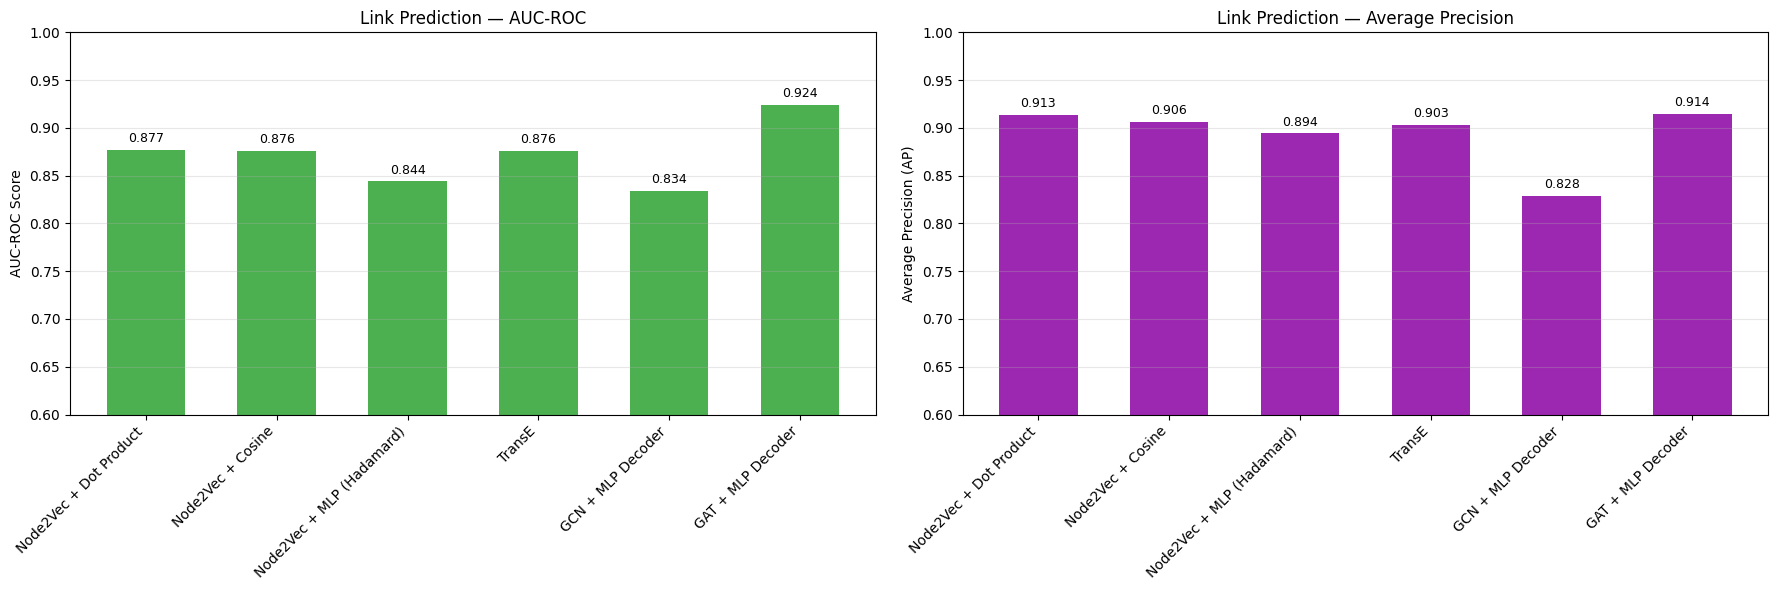

In [88]:
# ==============================================================================
# 17.2  Link Prediction Performance — Separate Bar Charts
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np

methods = list(results_b.keys())
aucs = [results_b[m]['auc'] for m in methods]
aps = [results_b[m]['ap'] for m in methods]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# --- AUC-ROC Chart ---
bars1 = ax1.bar(methods, aucs, color='#4CAF50', width=0.6)
ax1.set_ylabel('AUC-ROC Score')
ax1.set_title('Link Prediction — AUC-ROC')
ax1.set_xticklabels(methods, rotation=45, ha='right')
ax1.set_ylim(0.6, 1.0)
ax1.grid(axis='y', alpha=0.3)
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.005,
             f'{yval:.3f}', ha='center', va='bottom', fontsize=9)

# --- AP Chart ---
bars2 = ax2.bar(methods, aps, color='#9C27B0', width=0.6)
ax2.set_ylabel('Average Precision (AP)')
ax2.set_title('Link Prediction — Average Precision')
ax2.set_xticklabels(methods, rotation=45, ha='right')
ax2.set_ylim(0.6, 1.0)
ax2.grid(axis='y', alpha=0.3)
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.005,
             f'{yval:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 19. Conclusion and Key Findings

This project explored the transition from traditional, unsupervised graph analysis (Part 1) to supervised graph machine learning (Part 2) on the Cora citation network. Our experiments systematically evaluated the contribution of graph structure, node features, and deep learning architectures across two fundamental tasks: Node Classification and Link Prediction.

### 1. The Value of Combining Structure and Features
The node classification results clearly demonstrate that combining graph structure with textual features (Bag-of-Words) yields the best performance.
- **Features Only (BoW + LR)** achieved **75.8%** accuracy, establishing a strong baseline based purely on the text content of the papers.
- **Structure Only (Node2Vec, Laplacian Eigenmaps)** achieved **~81.0–81.5%** accuracy. Citation structure alone contains a strong signal about research topics due to the high homophily of the network (papers predominantly cite papers in the same field).
- **Structure + Features (GNNs)** dominated the task, with **GCN (88.6%)** and **GAT (88.0%)** showing that propagating rich text features through the citation topology provides a 7–13% absolute accuracy improvement over the baselines.

### 2. Embedding Quality and Cluster Separation
By computing the inter-class to intra-class distance ratio in the raw embedding space, we quantified how well each method separates the 7 topic classes:
- Shallow, unsupervised methods (BoW, Node2Vec, Laplacian Eigenmaps) produced ratios near **1.0** — classes are barely separated in embedding space.
- Supervised GNNs produced tightly clustered embeddings, with **GAT achieving the highest separation ratio (2.06)**, followed by GraphSAGE (1.88) and GCN (1.83), confirming that end-to-end supervised training shapes the embedding space explicitly for class discrimination.

### 3. The Over-smoothing Phenomenon
All GNN architectures peaked at **2 layers** and degraded with depth. GCN reached 88.7% at 2L and fell to 86.2% at 5L; GraphSAGE suffered the sharpest drop (83.4% at 5L). On a small, dense, homophilic graph like Cora (diameter ~8), deeper aggregation causes node representations to converge — washing out the local, class-specific signals that make GNNs effective.

### 4. Why GNNs Fail at some Cases: The Homophily Dependency
Our misclassification analysis revealed that GCN accuracy is tightly bound to **neighborhood homophily**. Papers surrounded by same-class neighbors (80–100% homophily) are classified at 96–98% accuracy. Bridge papers — sitting between communities with fewer than 40% same-class neighbors — are misclassified at 29–35%. This directly quantifies where and why message passing fails: aggregating mixed-class neighborhoods actively misleads the model.

### 5. Link Prediction Insights
- **GAT + MLP Decoder** was the clear winner (AUC-ROC **0.924**, AP **0.914**), with a +9pp gain over GCN + MLP (0.834) — the largest performance gap in the project. Attention-based aggregation is especially well-suited to link prediction since predicting specific edges requires knowing *which* neighbors are relevant.
- **Node2Vec + Dot Product** remained highly competitive (AUC 0.877) despite using no features, confirming that topological proximity is the dominant driver of citation likelihood.
- **Directionality did not help**: TransE (direction-aware) matched Node2Vec (undirected) almost exactly (0.876 vs. 0.877), consistent with Cora's high homophily making the "cites" direction largely redundant.

### Summary
Part 1 established that Cora's citation graph has strong structural properties (modularity 0.82) that partially align with research topics. Part 2 proved that supervised GNNs can exploit this structure far more effectively: by fusing topological aggregation with 1433-d textual features, 2-layer GCNs and GATs vastly outperform methods that rely on either structure or features alone. The key lessons are clear — **2 layers is optimal**, **attention matters for link prediction**, and **GNN performance is fundamentally bounded by neighborhood homophily**.
